In [39]:
import sys
import os
from dotenv import load_dotenv

import geopandas as gpd
import sqlalchemy as sq
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm, colors

sys.path.append("../")
from Shared.DataService import DataService

ModuleNotFoundError: No module named 'tensorflow_data_validation'

In [2]:
load_dotenv()
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")

In [3]:
# connecting to database
db = DataService(PG_DB, PG_ADDR, PG_PORT, PG_USER, PG_PW)
conn = db.connect()

In [4]:
query = sq.text("select * FROM public.ergot_sample")
ergot_df = pd.read_sql(query, conn)

In [5]:
ergot_df

sample_id  year province  crop_district  incidence  severity
0               1  1995       AB              1      False       0.0
1               2  1995       AB              1      False       0.0
2               3  1995       AB              1      False       0.0
3               4  1995       AB              1      False       0.0
4               5  1995       AB              1      False       0.0
...           ...   ...      ...            ...        ...       ...
158684     158685  2022       SK             81      False       0.0
158685     158686  2022       SK             81      False       0.0
158686     158687  2022       SK             81      False       0.0
158687     158688  2022       AB              7      False       0.0
158688     158689  2022       AB              7      False       0.0

[158689 rows x 6 columns]

In [6]:
# car : canadian agriculture region
ergot_df.loc[ergot_df["province"] == "MB", "car_uid"] = ergot_df.loc[ergot_df["province"] == "MB", "crop_district"] + 4600
ergot_df.loc[ergot_df["province"] == "SK", "car_uid"] = (ergot_df.loc[ergot_df["province"] == "SK", "crop_district"] - 1) + 4700
ergot_df.loc[ergot_df["province"] == "AB", "car_uid"] = (ergot_df.loc[ergot_df["province"] == "AB", "crop_district"] * 10) + 4800

In [7]:
ergot_df.drop(columns=['crop_district', 'sample_id'], inplace=True)

In [8]:
ergot_df['car_uid'] = pd.to_numeric(ergot_df['car_uid'], downcast='integer')
ergot_df

year province  incidence  severity  car_uid
0       1995       AB      False       0.0     4810
1       1995       AB      False       0.0     4810
2       1995       AB      False       0.0     4810
3       1995       AB      False       0.0     4810
4       1995       AB      False       0.0     4810
...      ...      ...        ...       ...      ...
158684  2022       SK      False       0.0     4780
158685  2022       SK      False       0.0     4780
158686  2022       SK      False       0.0     4780
158687  2022       AB      False       0.0     4870
158688  2022       AB      False       0.0     4870

[158689 rows x 5 columns]

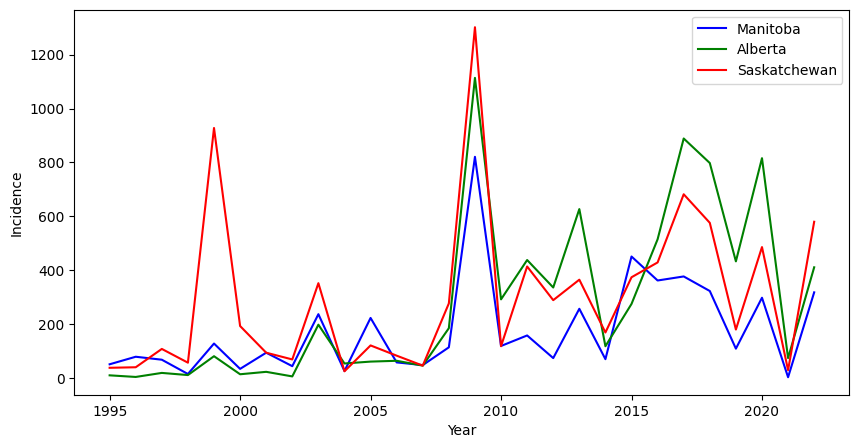

In [9]:
# sample with incidence = True: per year, per province
samples_df = ergot_df[ergot_df['incidence'] == True].groupby(['province', 'year'])['incidence'].count().reset_index()
mb_df = samples_df[samples_df['province'] == 'MB']
ab_df = samples_df[samples_df['province'] == 'AB']
sk_df = samples_df[samples_df['province'] == 'SK']

year = mb_df['year'].tolist()
mb_incidence = mb_df['incidence'].tolist()
ab_incidence = ab_df['incidence'].tolist()
sk_incidence = sk_df['incidence'].tolist()


plt.figure(figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Incidence')
plt.plot(year, mb_incidence, color="blue")
plt.plot(year, ab_incidence, color="green")
plt.plot(year, sk_incidence, color="red")
plt.legend(['Manitoba', 'Alberta', 'Saskatchewan'])
plt.show()


In [10]:
ratio_df = ergot_df.groupby(['province', 'year'])['incidence'].count().reset_index()
ratio_df['ratio'] = (samples_df['incidence']/ratio_df['incidence']).to_frame()
ratio_df.drop(columns = {'incidence'}, inplace=True)
ratio_df

province  year     ratio
0        AB  1995  0.003510
1        AB  1996  0.001050
2        AB  1997  0.005782
3        AB  1998  0.006448
4        AB  1999  0.038682
..      ...   ...       ...
79       SK  2018  0.225088
80       SK  2019  0.063852
81       SK  2020  0.232982
82       SK  2021  0.018035
83       SK  2022  0.386409

[84 rows x 3 columns]

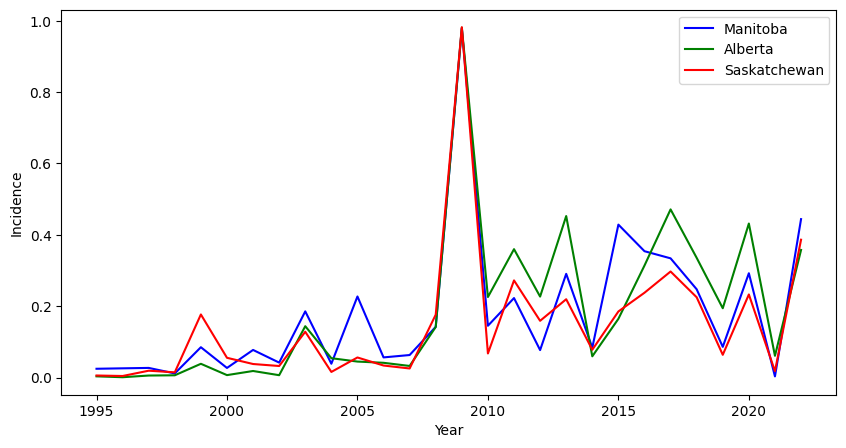

Highest ratio in MB: 0.9785458879618594, in year: 2009
Highest ratio in AB: 0.9806338028169014, in year: 2009
Highest ratio in SK: 0.9819004524886877, in year: 2009
Lowest ratio in MB: 0.0033482142857142855, in year: 2021
Lowest ratio in AB: 0.0010495932826029913, in year: 1996
Lowest ratio in SK: 0.0044662795891022775, in year: 1996


In [11]:
# Min, max for each province
mb_ratio = ratio_df[ratio_df['province'] == 'MB']['ratio'].tolist()
ab_ratio = ratio_df[ratio_df['province'] == 'AB']['ratio'].tolist()
sk_ratio = ratio_df[ratio_df['province'] == 'SK']['ratio'].tolist()


plt.figure(figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Incidence')
plt.plot(year, mb_ratio, color="blue")
plt.plot(year, ab_ratio, color="green")
plt.plot(year, sk_ratio, color="red")
plt.legend(['Manitoba', 'Alberta', 'Saskatchewan'])
plt.show()

print('Highest ratio in MB: {}, in year: {}'.format(max(mb_ratio), mb_ratio.index(max(mb_ratio)) + 1995))
print('Highest ratio in AB: {}, in year: {}'.format(max(ab_ratio), ab_ratio.index(max(ab_ratio)) + 1995))
print('Highest ratio in SK: {}, in year: {}'.format(max(sk_ratio), sk_ratio.index(max(sk_ratio)) + 1995))

print('Lowest ratio in MB: {}, in year: {}'.format(min(mb_ratio), mb_ratio.index(min(mb_ratio)) + 1995))
print('Lowest ratio in AB: {}, in year: {}'.format(min(ab_ratio), ab_ratio.index(min(ab_ratio)) + 1995))
print('Lowest ratio in SK: {}, in year: {}'.format(min(sk_ratio), sk_ratio.index(min(sk_ratio)) + 1995))

In [12]:
total_df = ergot_df.groupby(['year', 'car_uid'])['incidence'].count().reset_index()
region_df = ergot_df[ergot_df['incidence'] == True].groupby(['province', 'year', 'car_uid'])['incidence'].count().reset_index()
region_df['ratio'] = (region_df['incidence']/total_df['incidence']) * 100
region_df


province  year  car_uid  incidence      ratio
0         AB  1995     4830          2   0.925926
1         AB  1995     4840          5   2.092050
2         AB  1995     4850          2   0.970874
3         AB  1995     4870          1   1.098901
4         AB  1996     4820          1   1.754386
..       ...   ...      ...        ...        ...
876       SK  2022     4771         47  34.306569
877       SK  2022     4780         43  28.666667
878       SK  2022     4781         37  43.529412
879       SK  2022     4790         27  30.337079
880       SK  2022     4791         29  32.584270

[881 rows x 5 columns]

In [13]:
regionQuery = sq.text("select district, color, geometry FROM public.census_ag_regions")
agRegions = gpd.GeoDataFrame.from_postgis(
    regionQuery, conn, crs="EPSG:3347", geom_col="geometry"
)

In [14]:
def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=100):
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm(abs(value)))[:3]
    color = colors.rgb2hex(rgb)
    return color

In [15]:
def get_color(ratio_year):
    color_map = []
    for district in agRegions['district'].tolist():
        if district in ratio_year['car_uid'].tolist():
            ratio = ratio_year[ratio_year['car_uid'] == district]['ratio'].tolist()[0]
            color_map.append(color_map_color(ratio))
        else:
            color_map.append(color_map_color(0))
    return pd.Series(color_map)

In [16]:
def plot_map(color_map, year):
    minx, miny, maxx, maxy = agRegions.total_bounds
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_ylim(miny, maxy)
    ax.set_xlim(minx, maxx)
    ax.set_title("Incident level for district in " + str(year))
    agRegions.plot(ax=ax, color=color_map, edgecolor="black")
    agRegions.apply(
        lambda x: ax.annotate(
            text=x["district"],
            xy=x.geometry.centroid.coords[0],
            ha="center",
            color="black",
            size=10,
        ),
        axis=1,
    )
    plt.show()

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


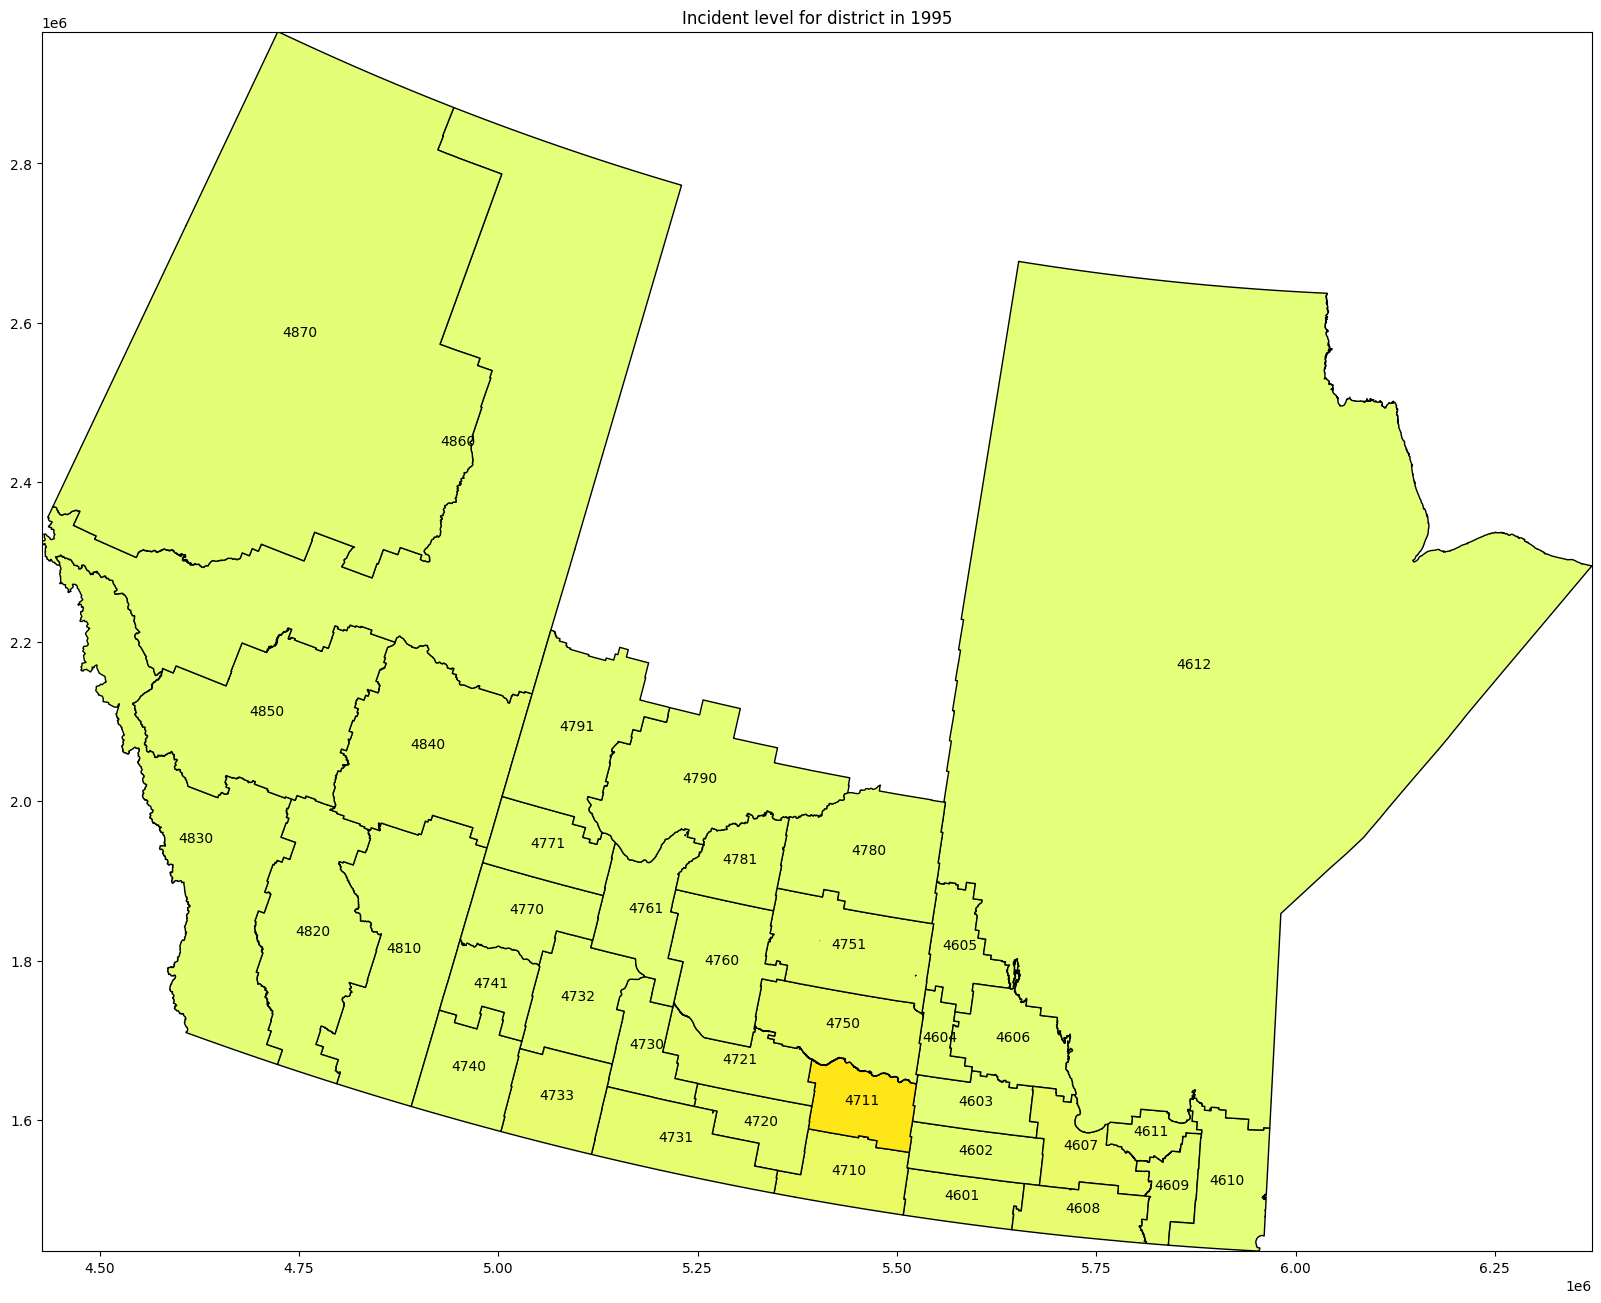

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


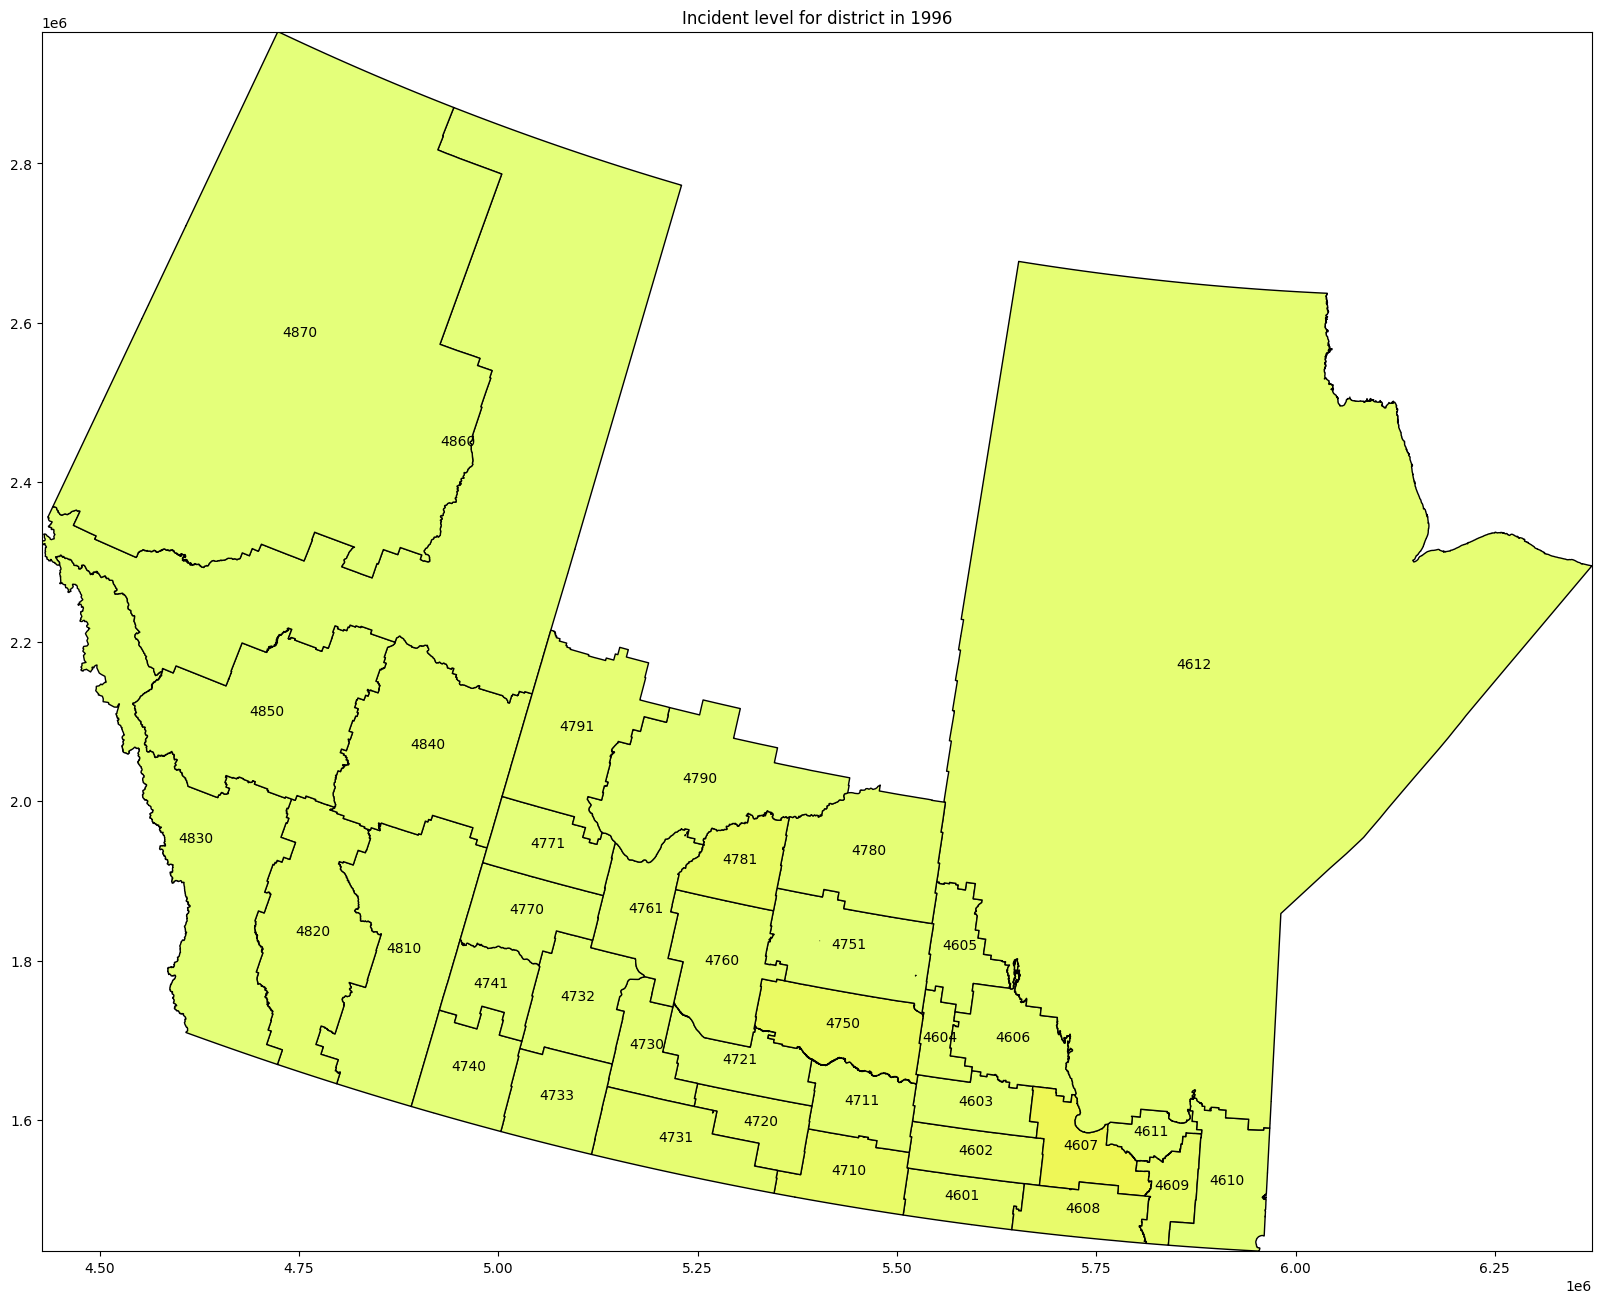

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


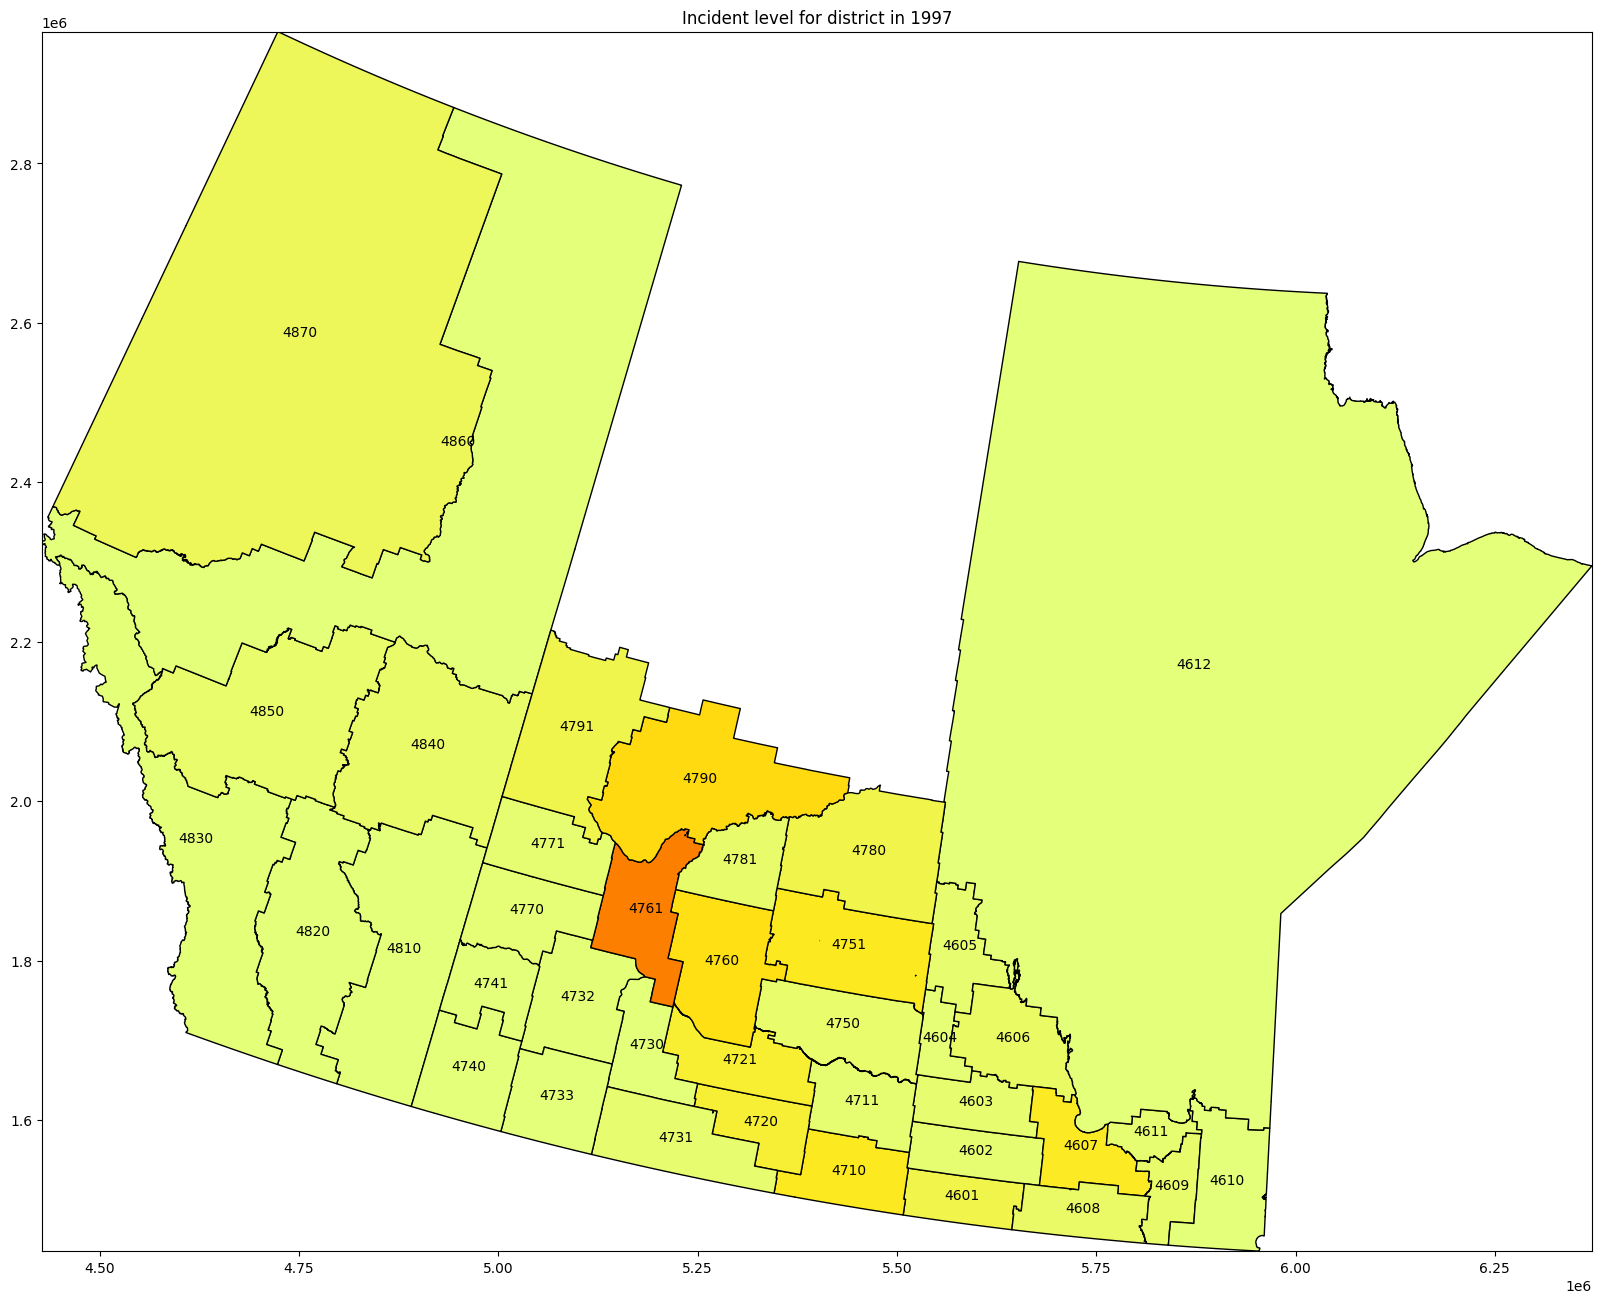

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


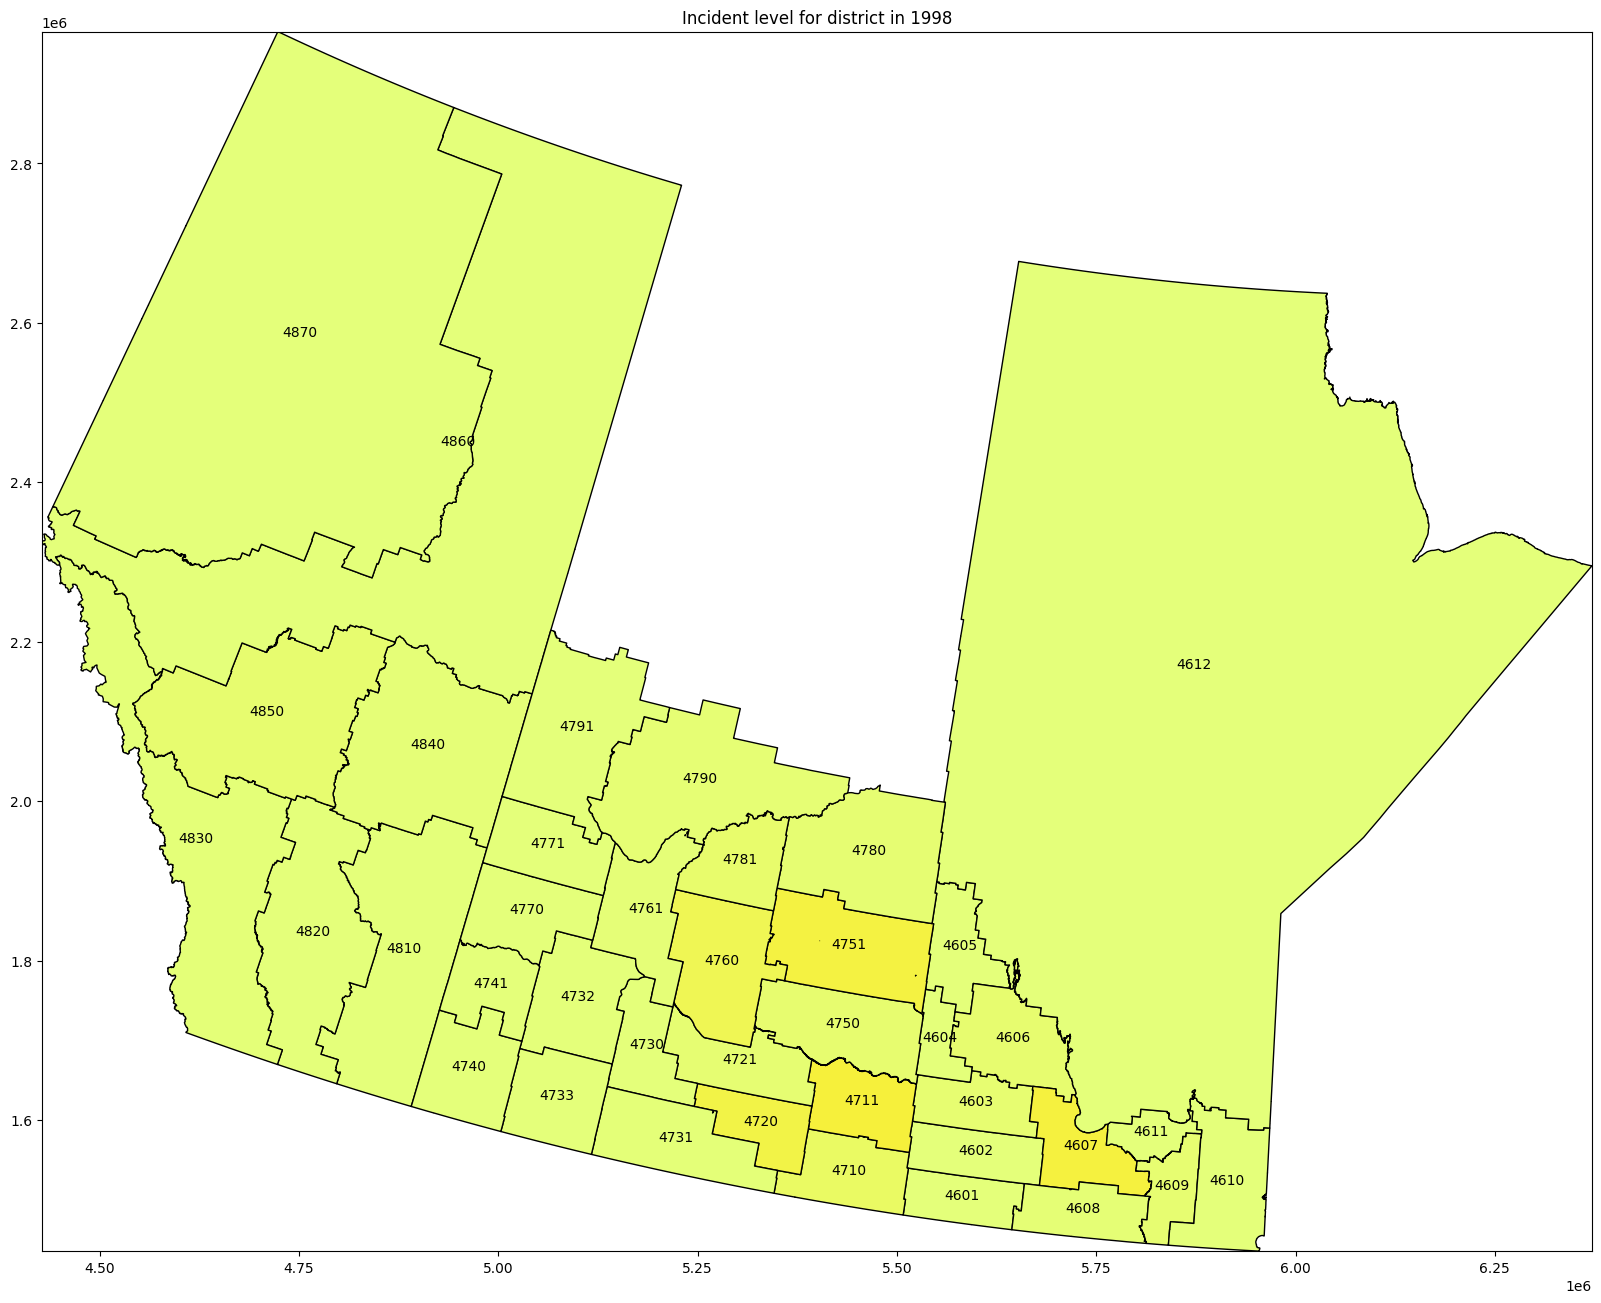

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


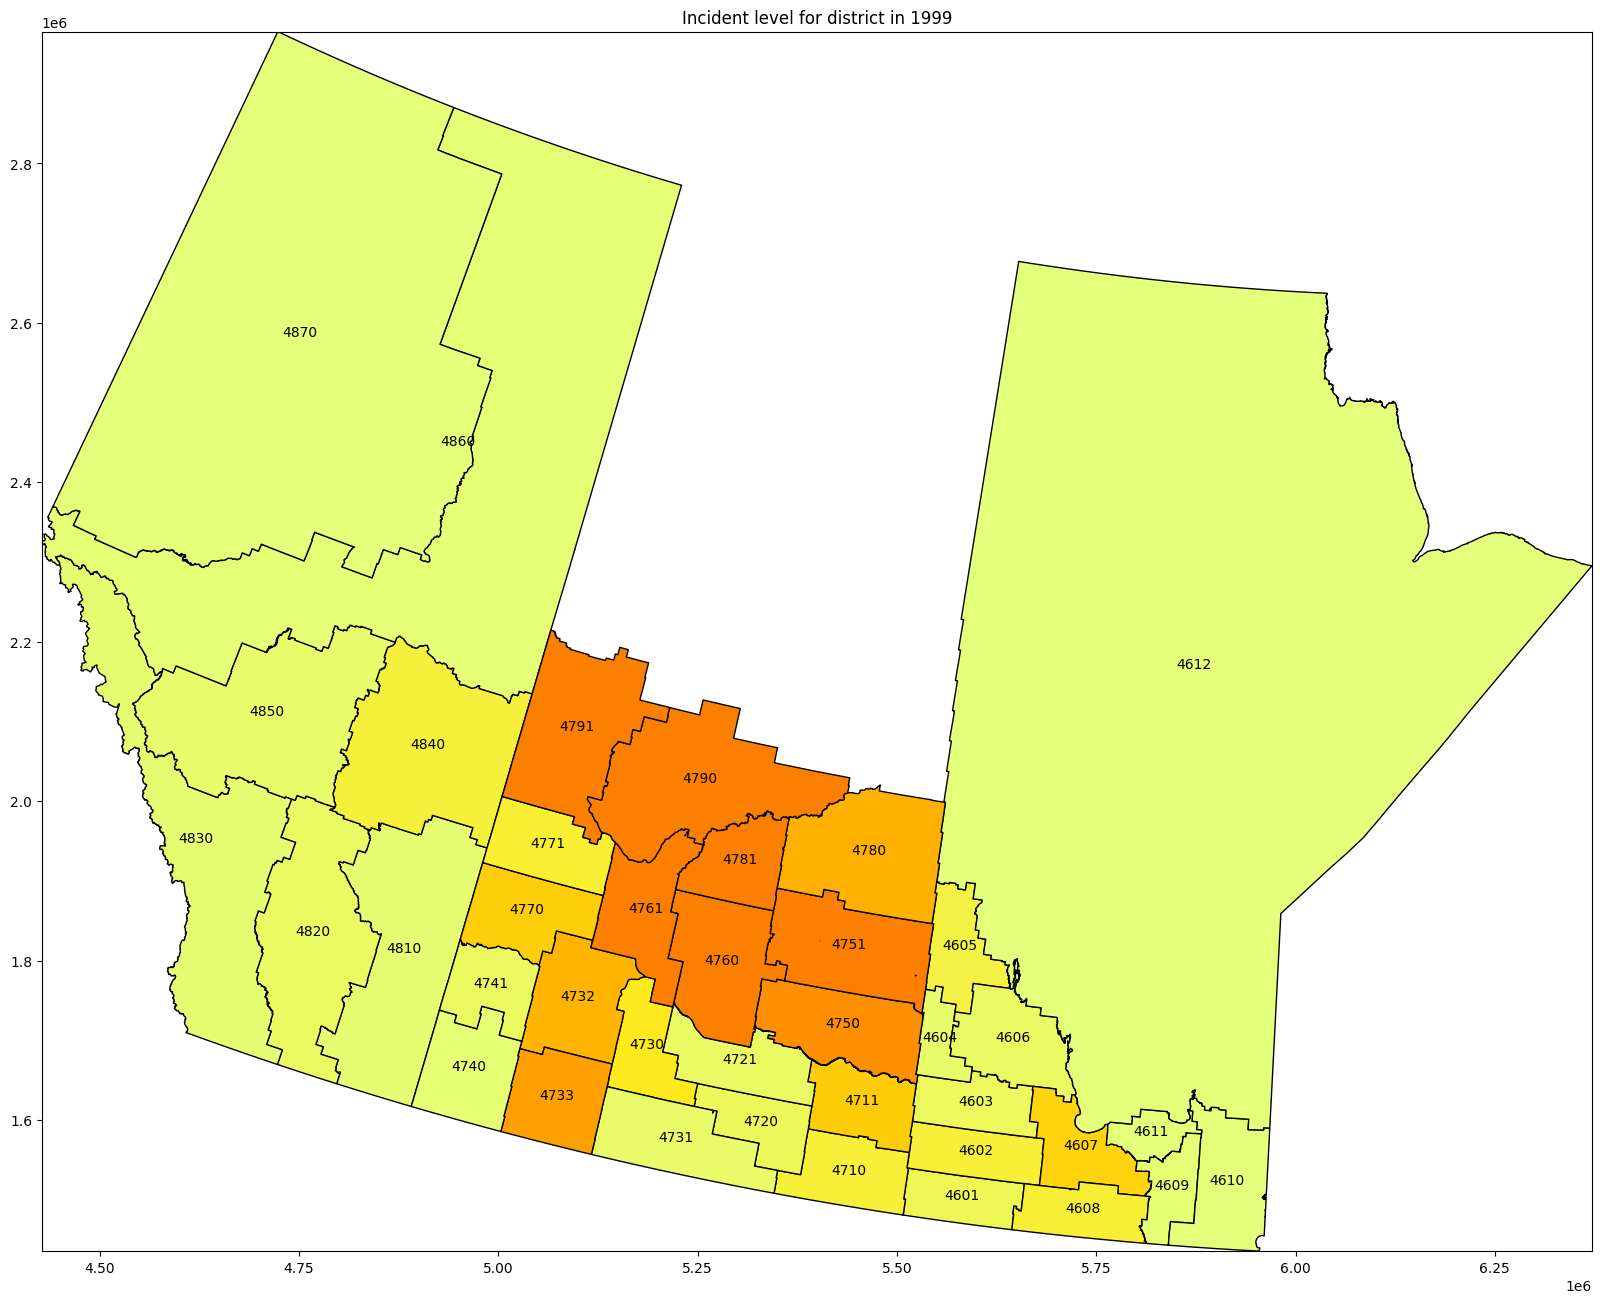

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


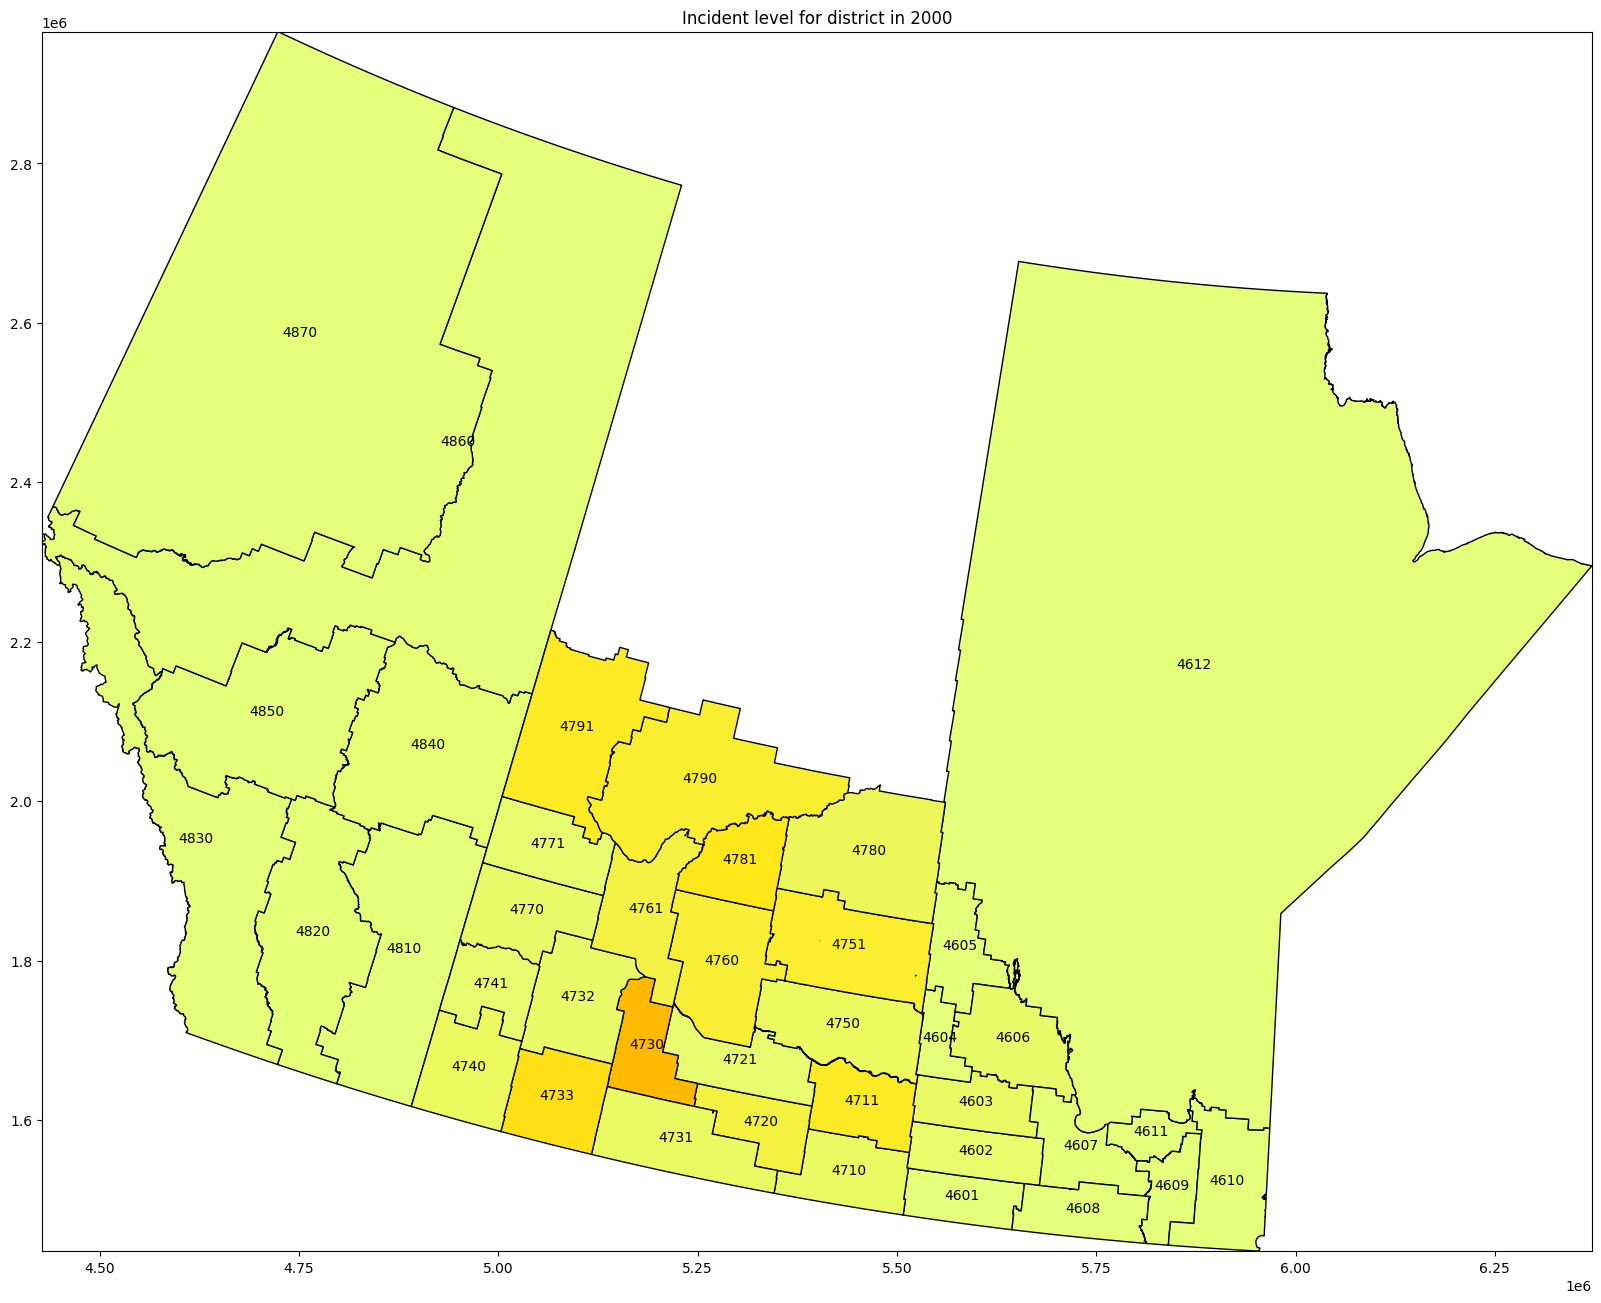

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


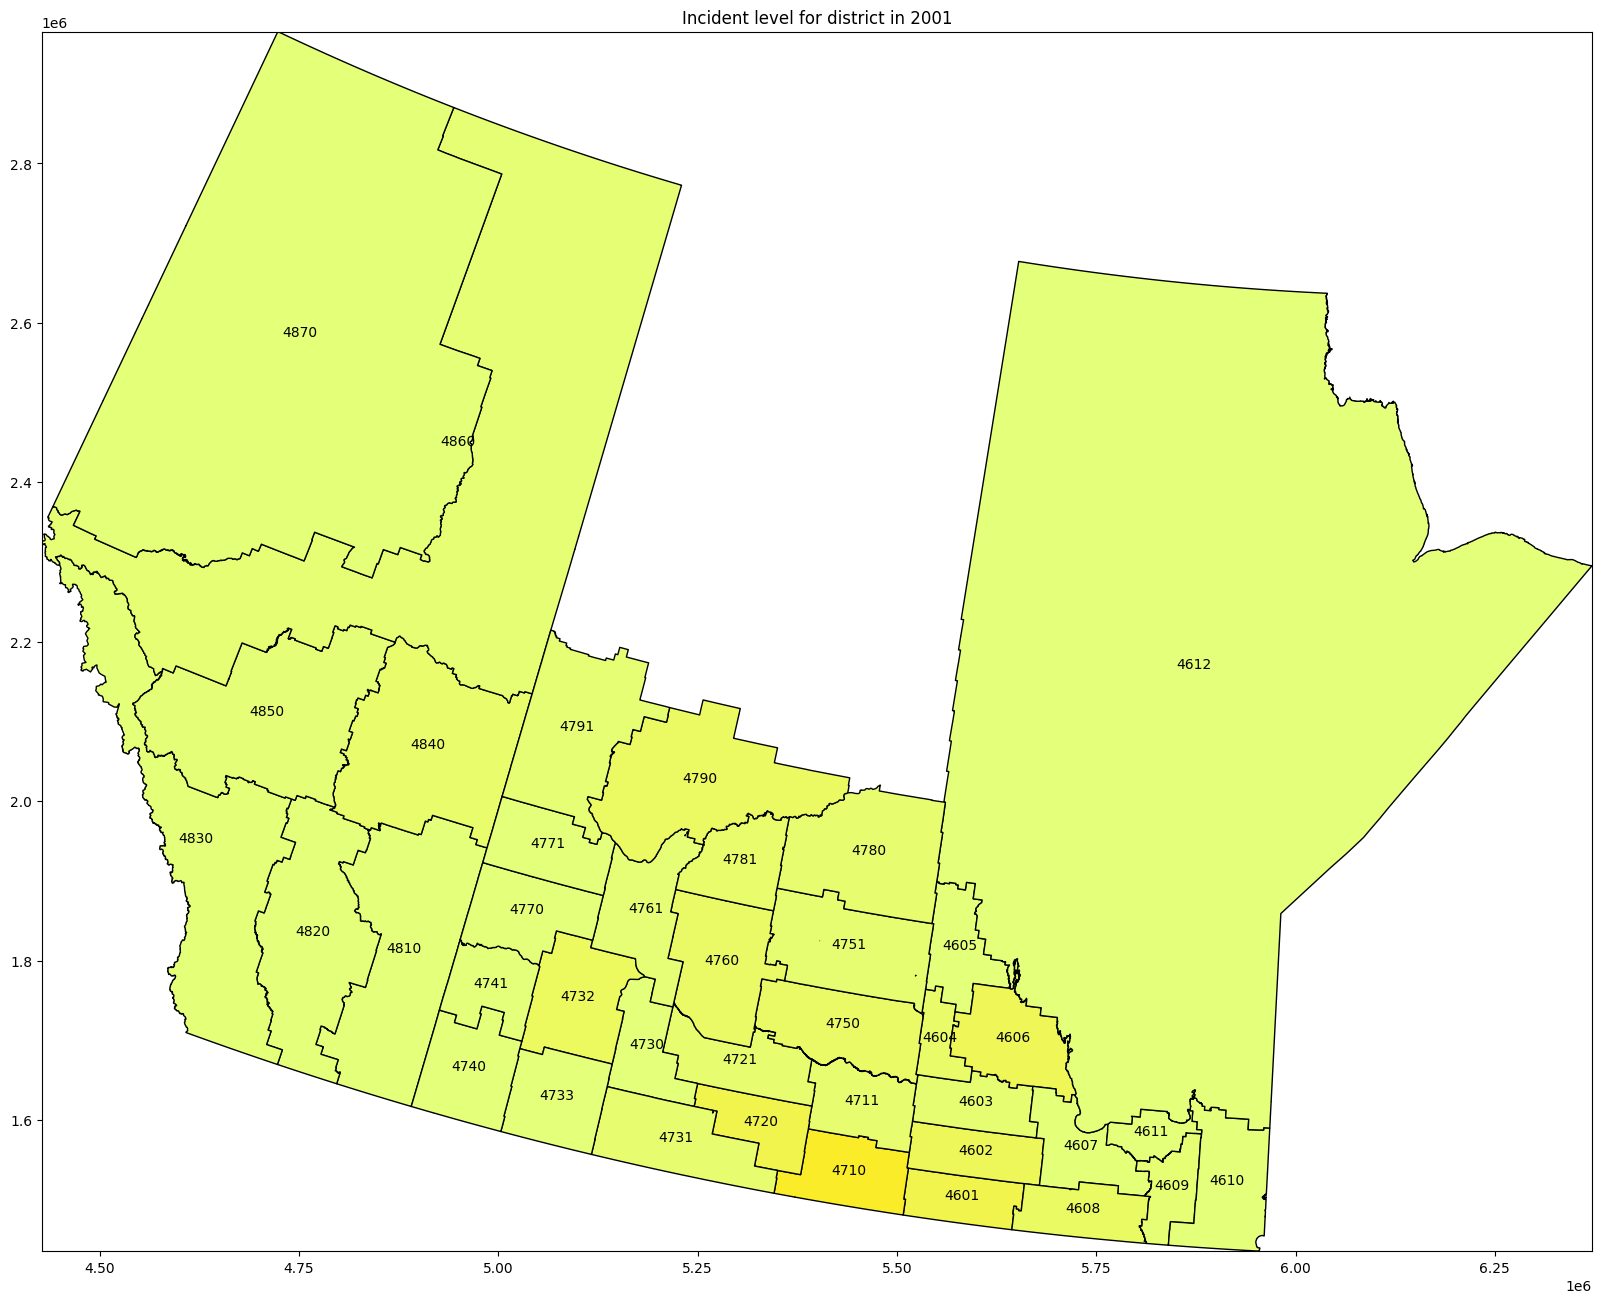

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


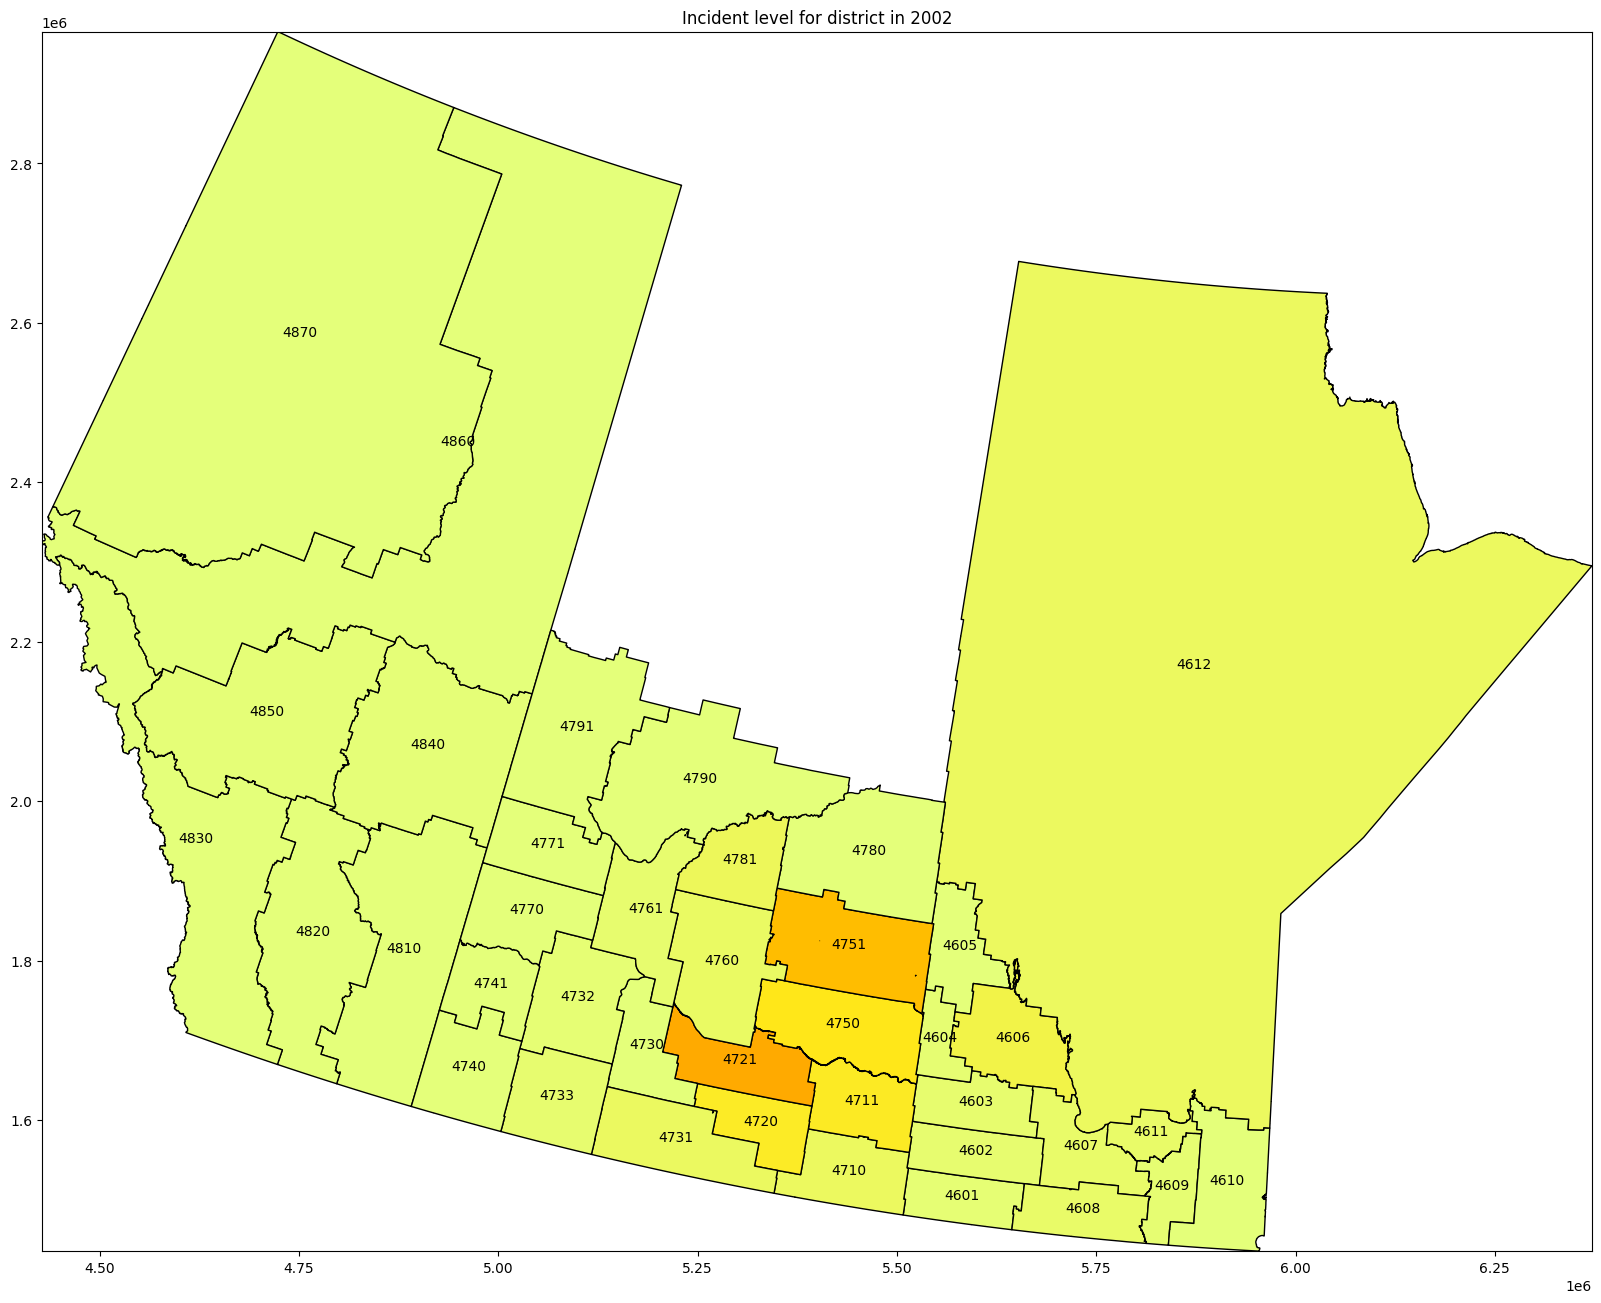

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


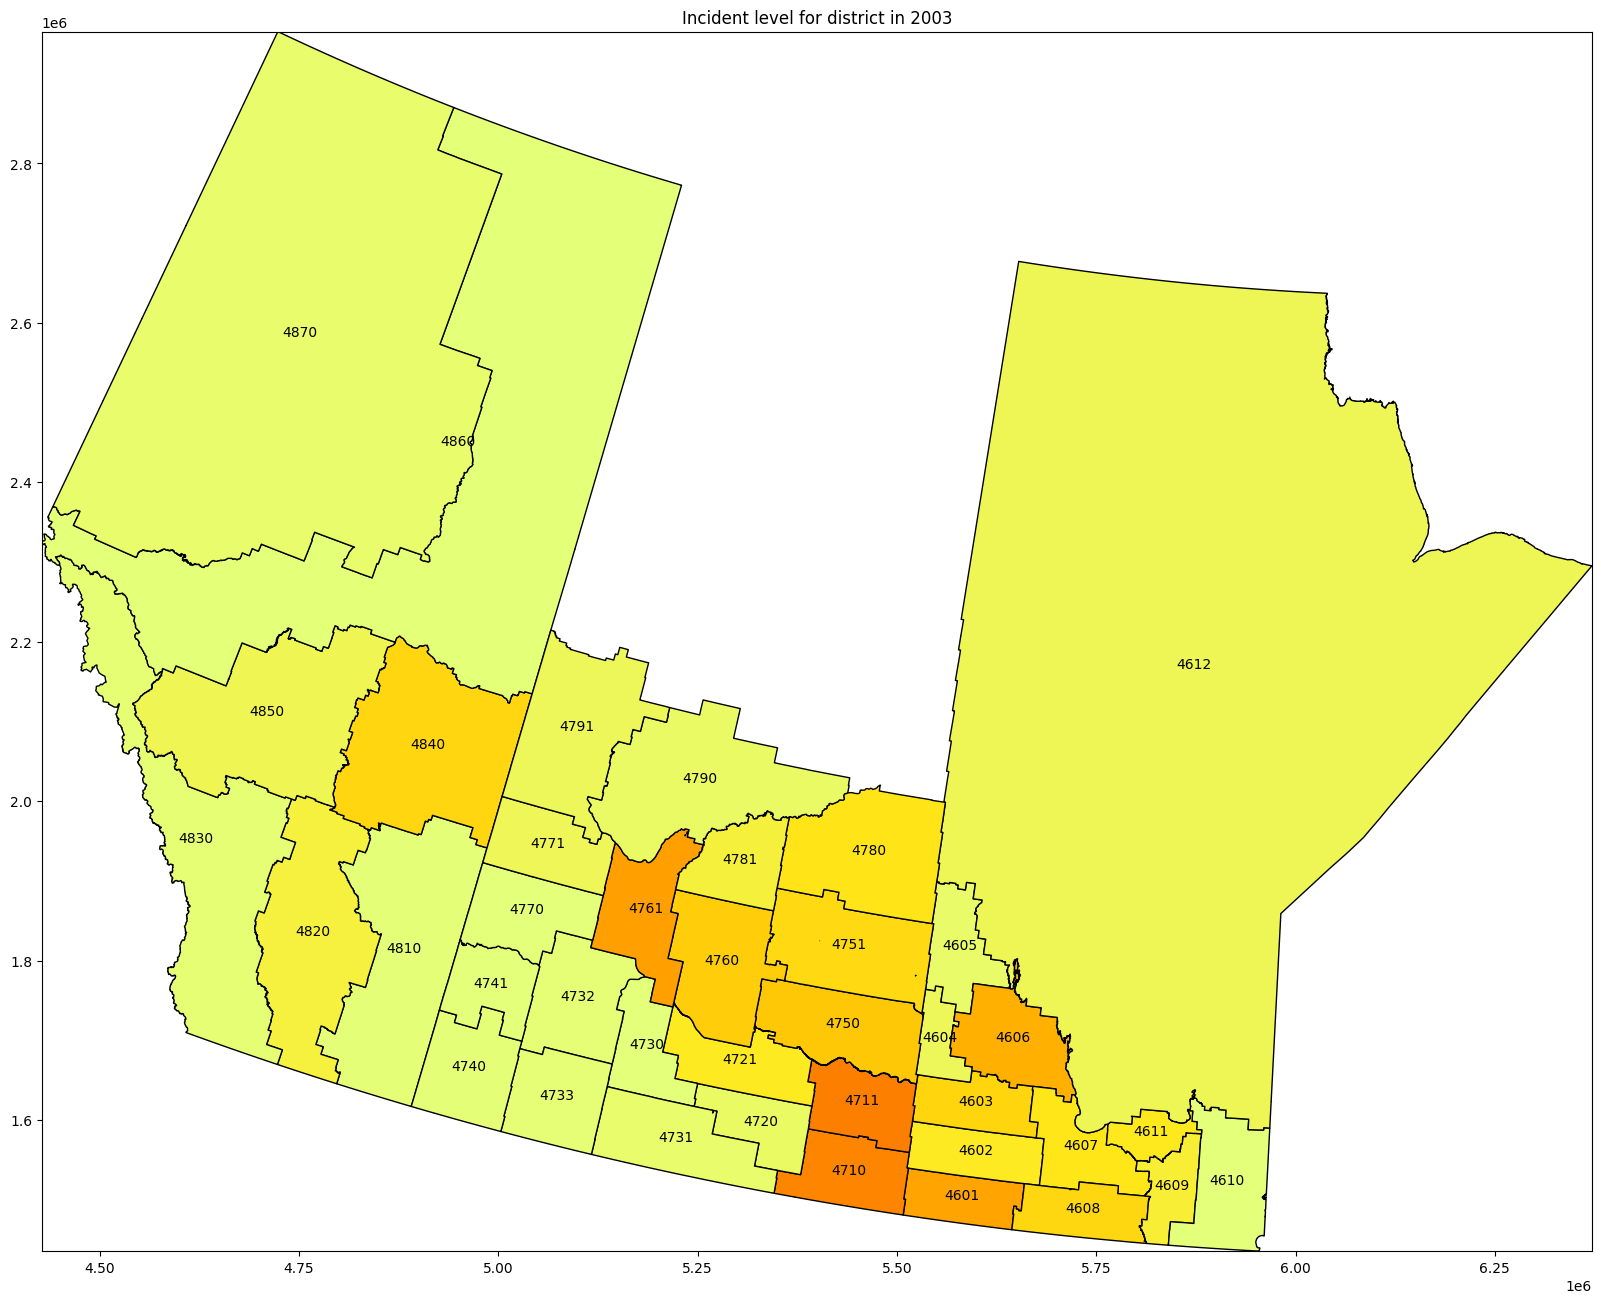

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


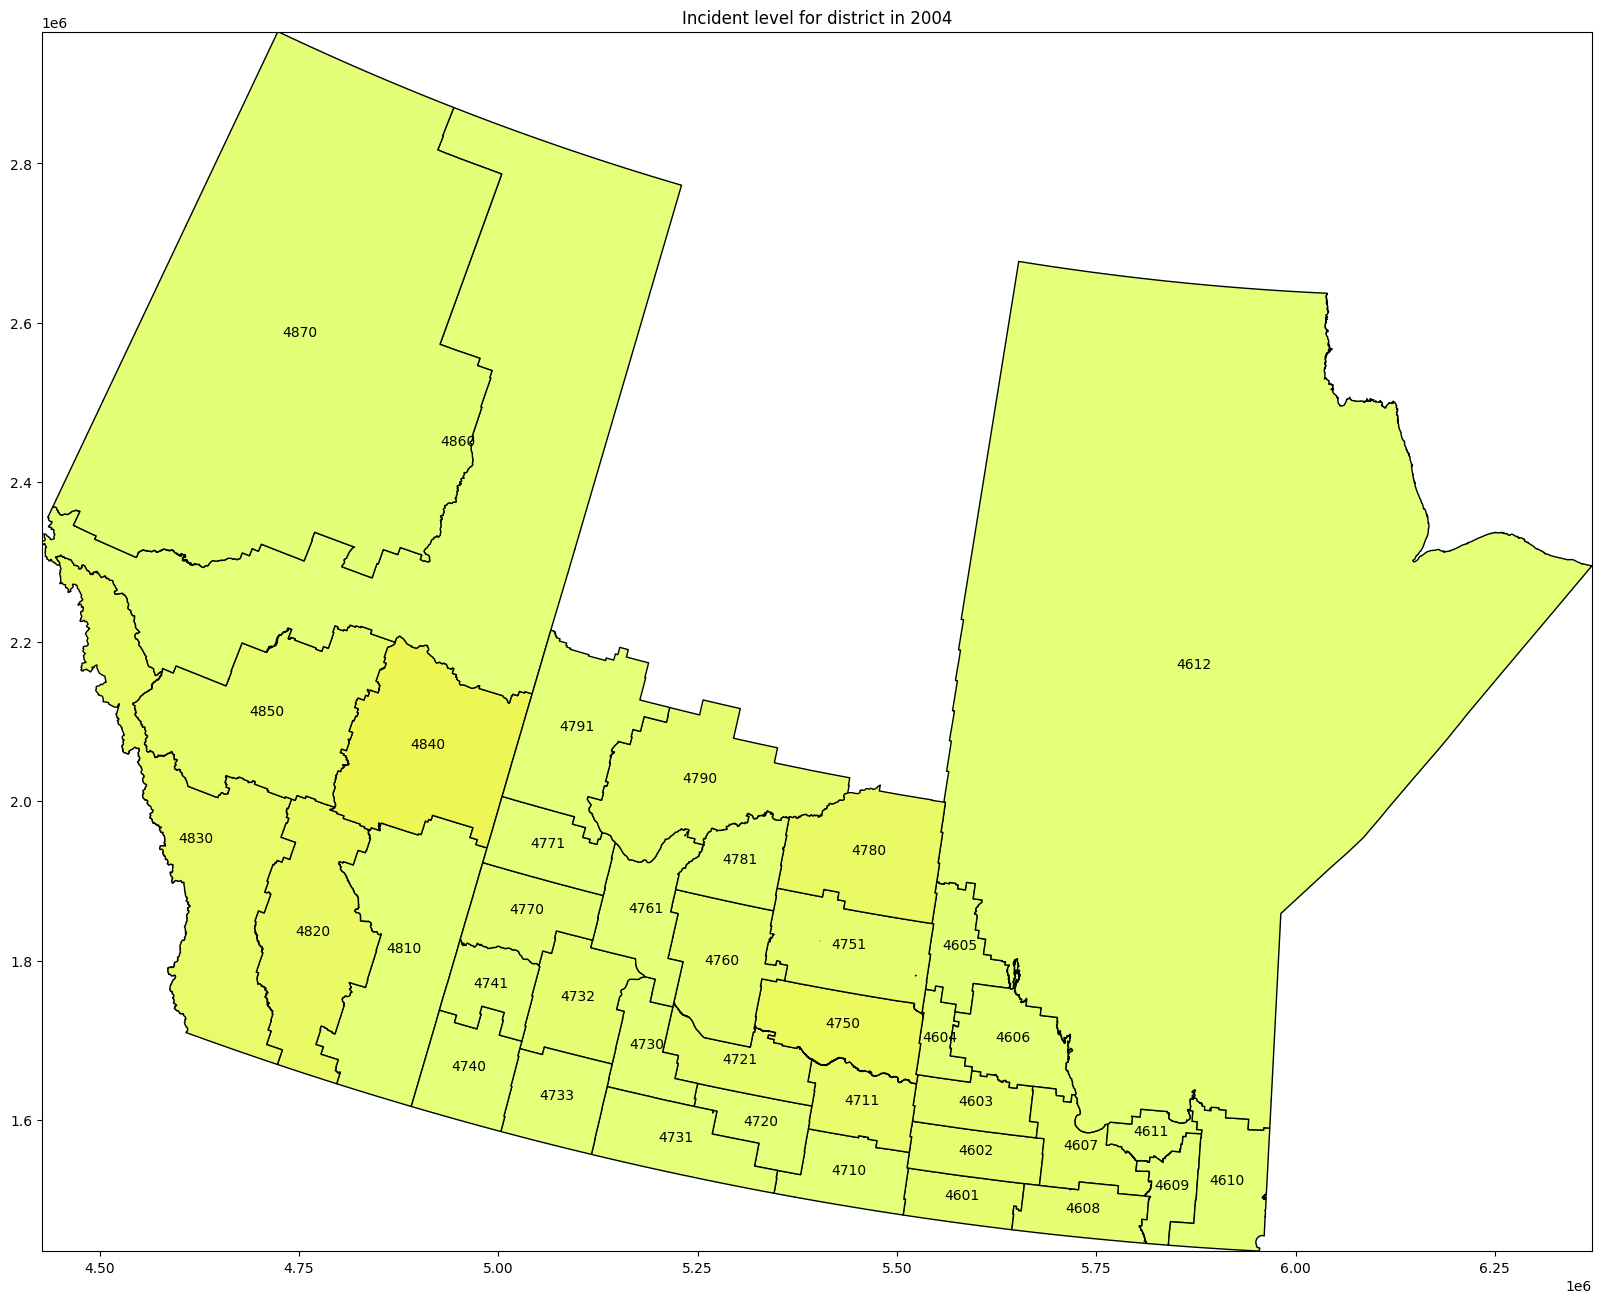

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


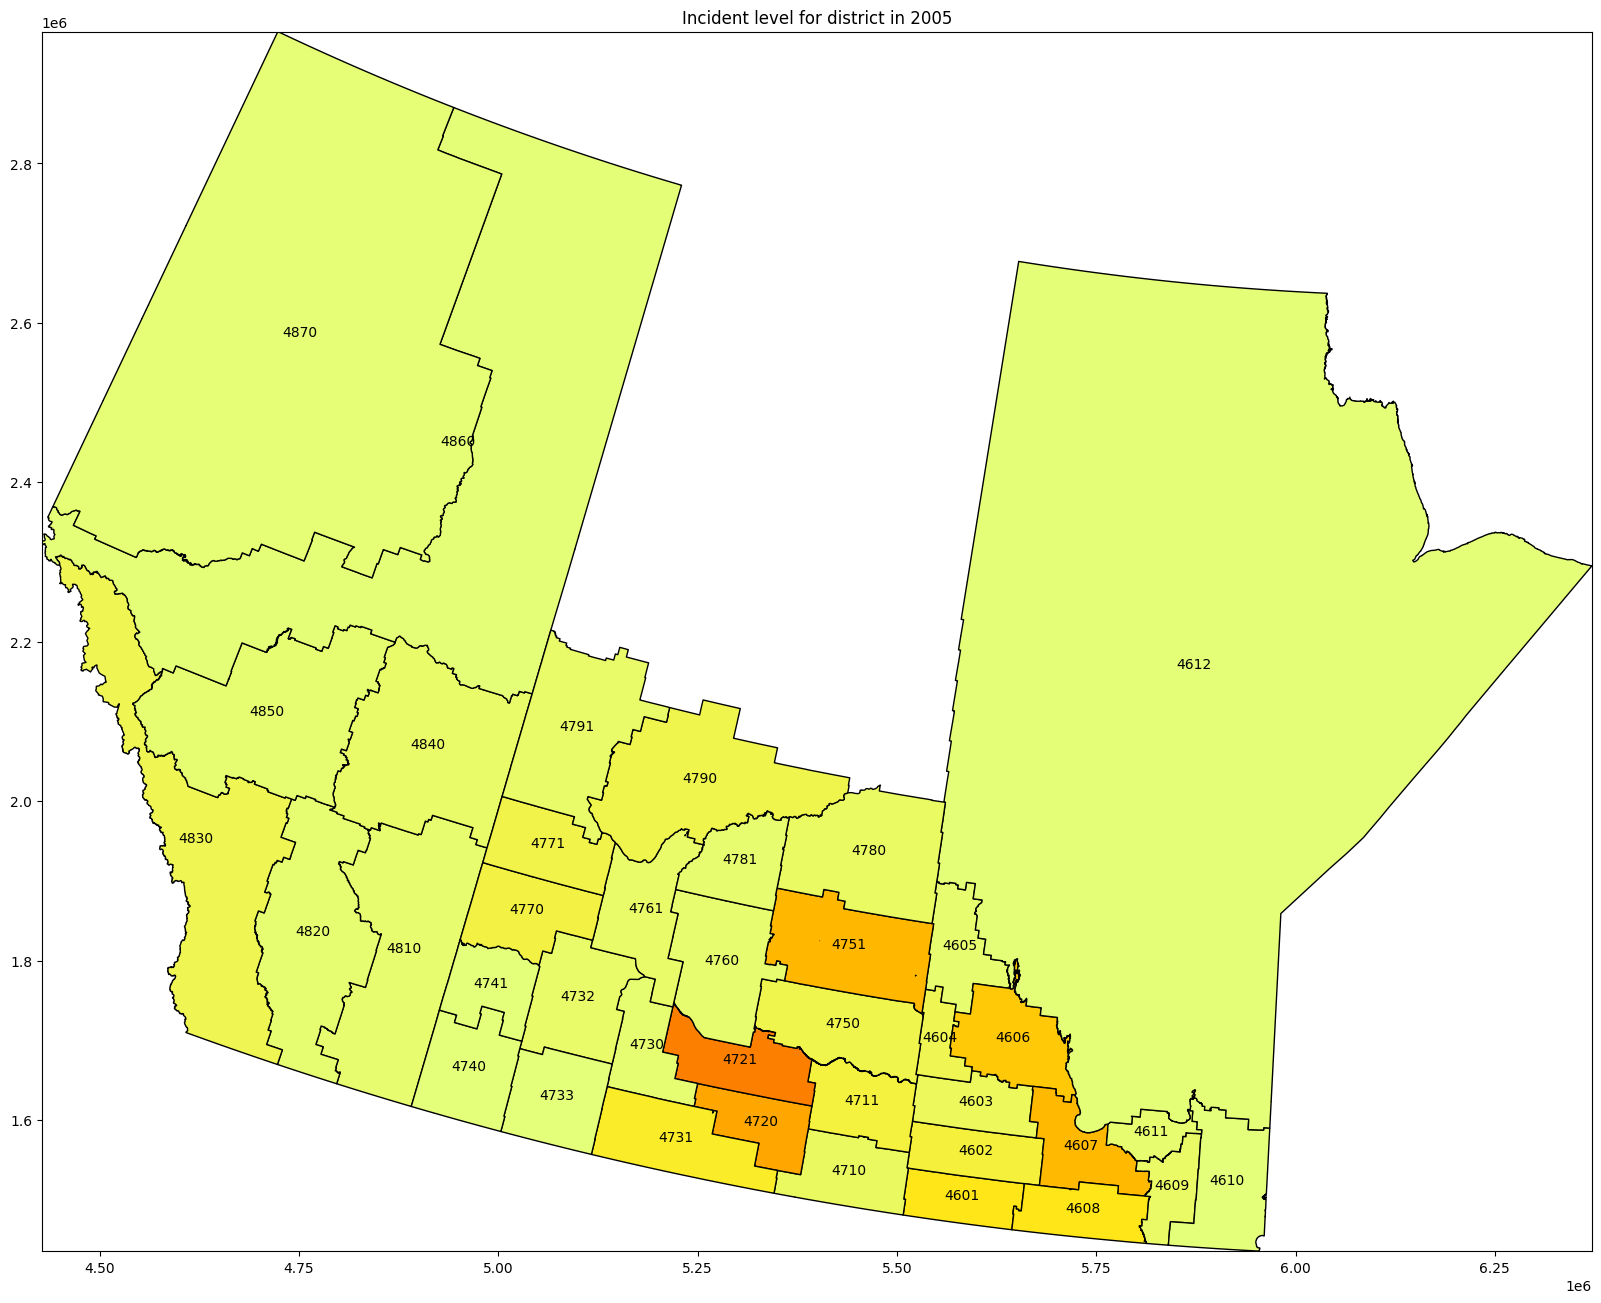

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


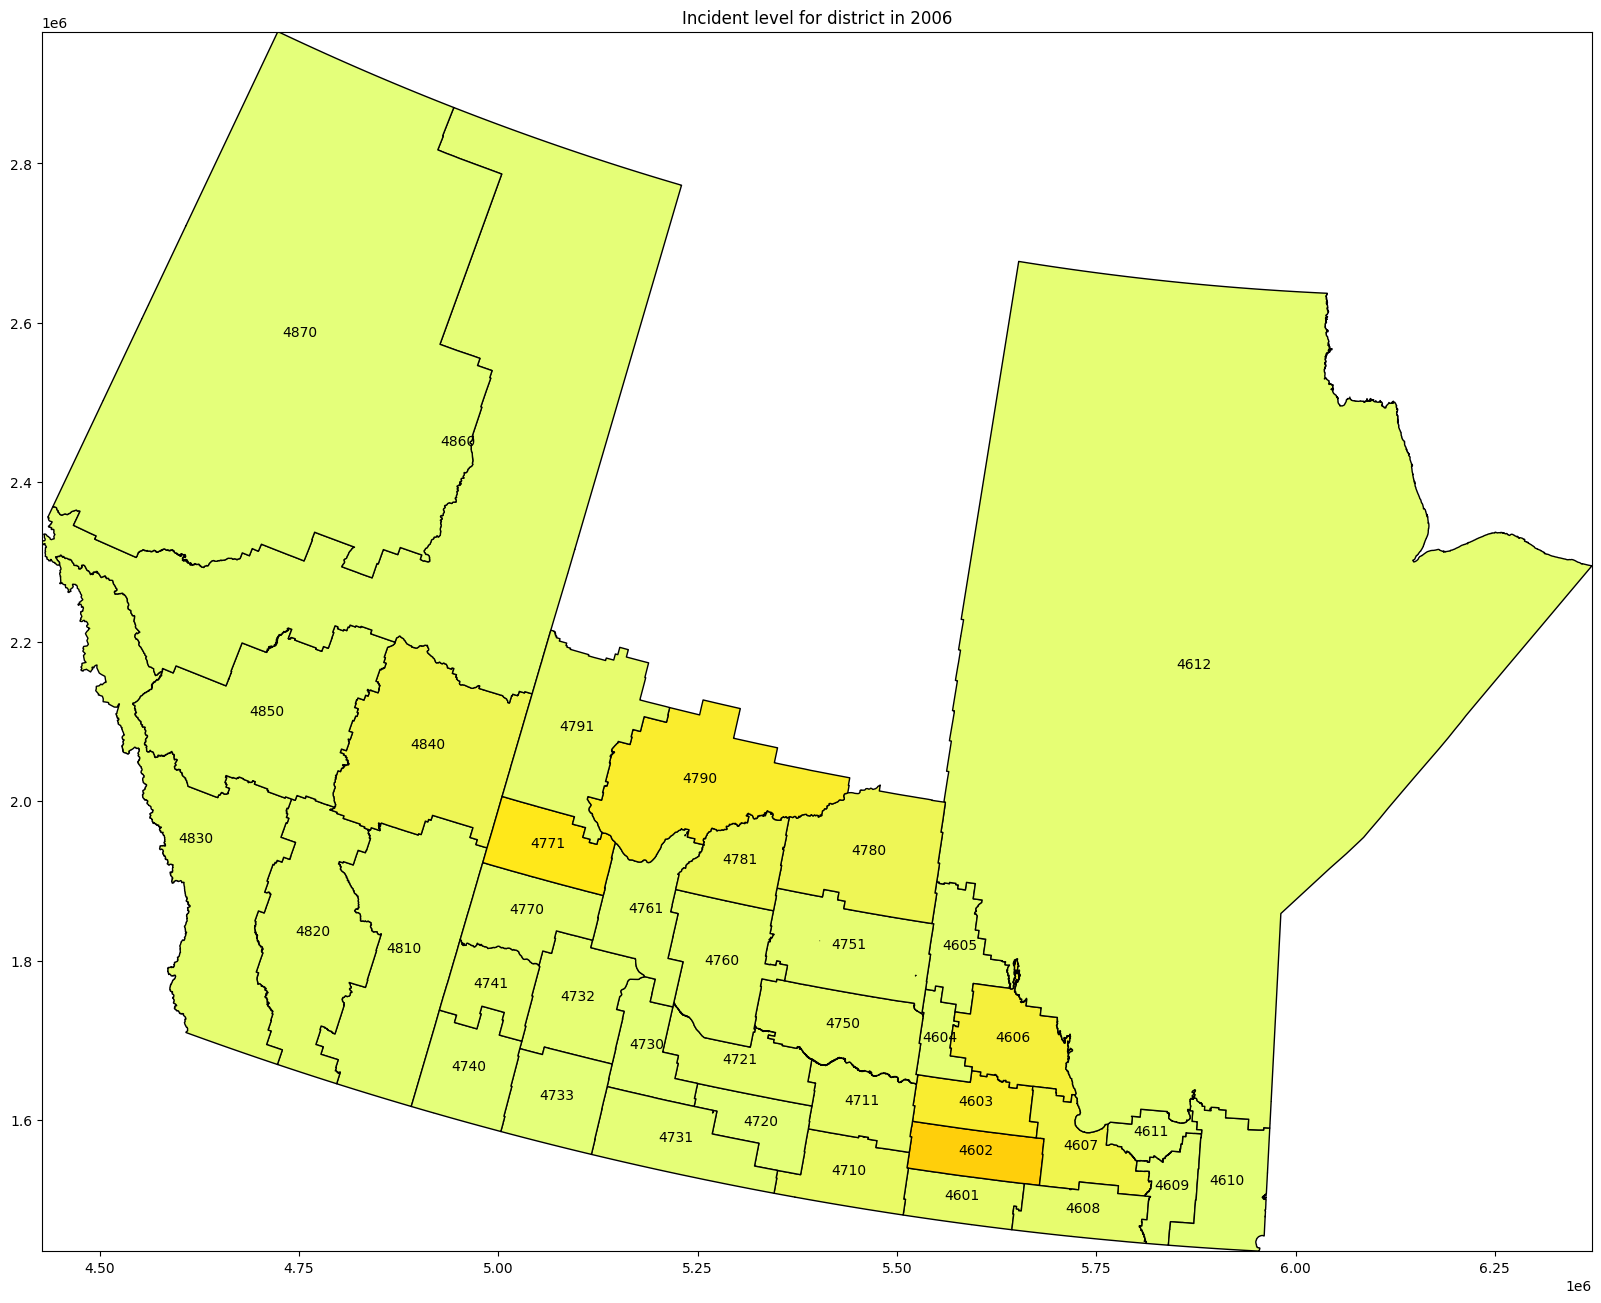

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


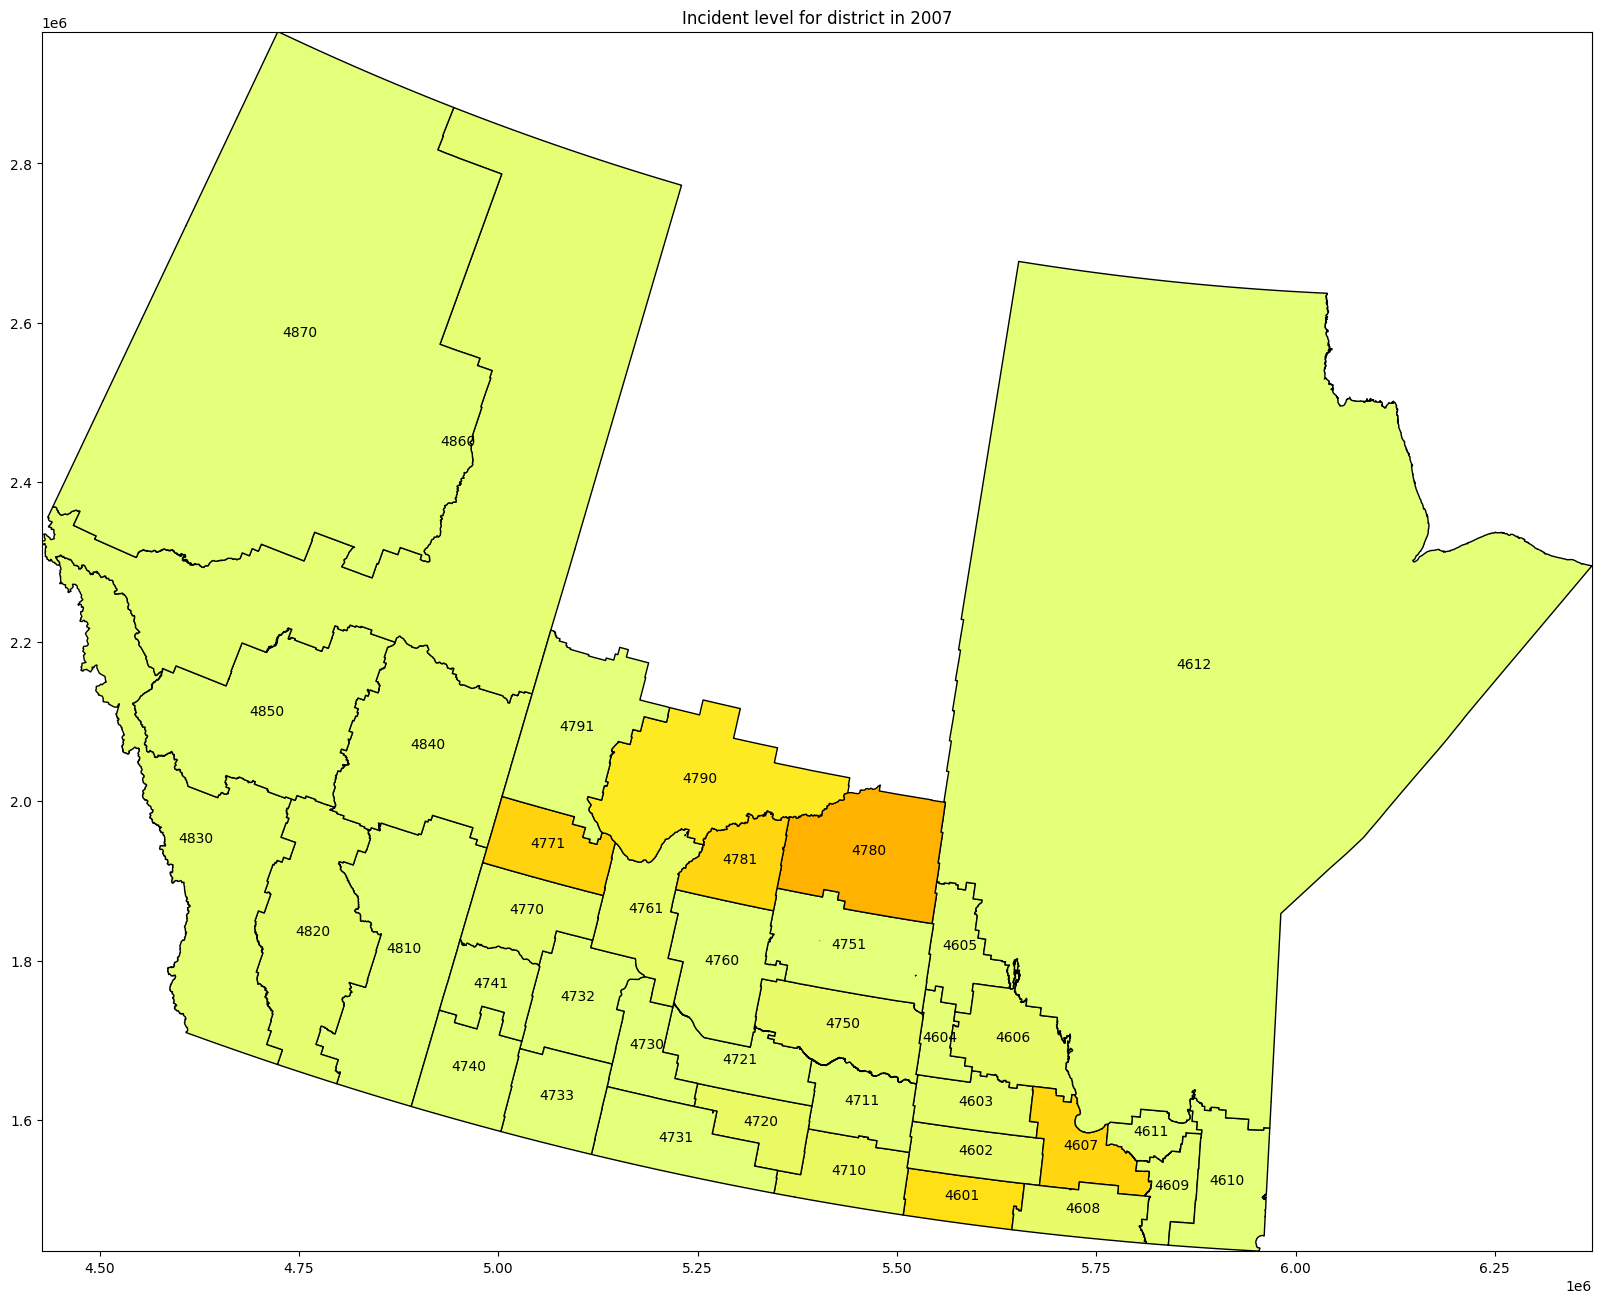

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


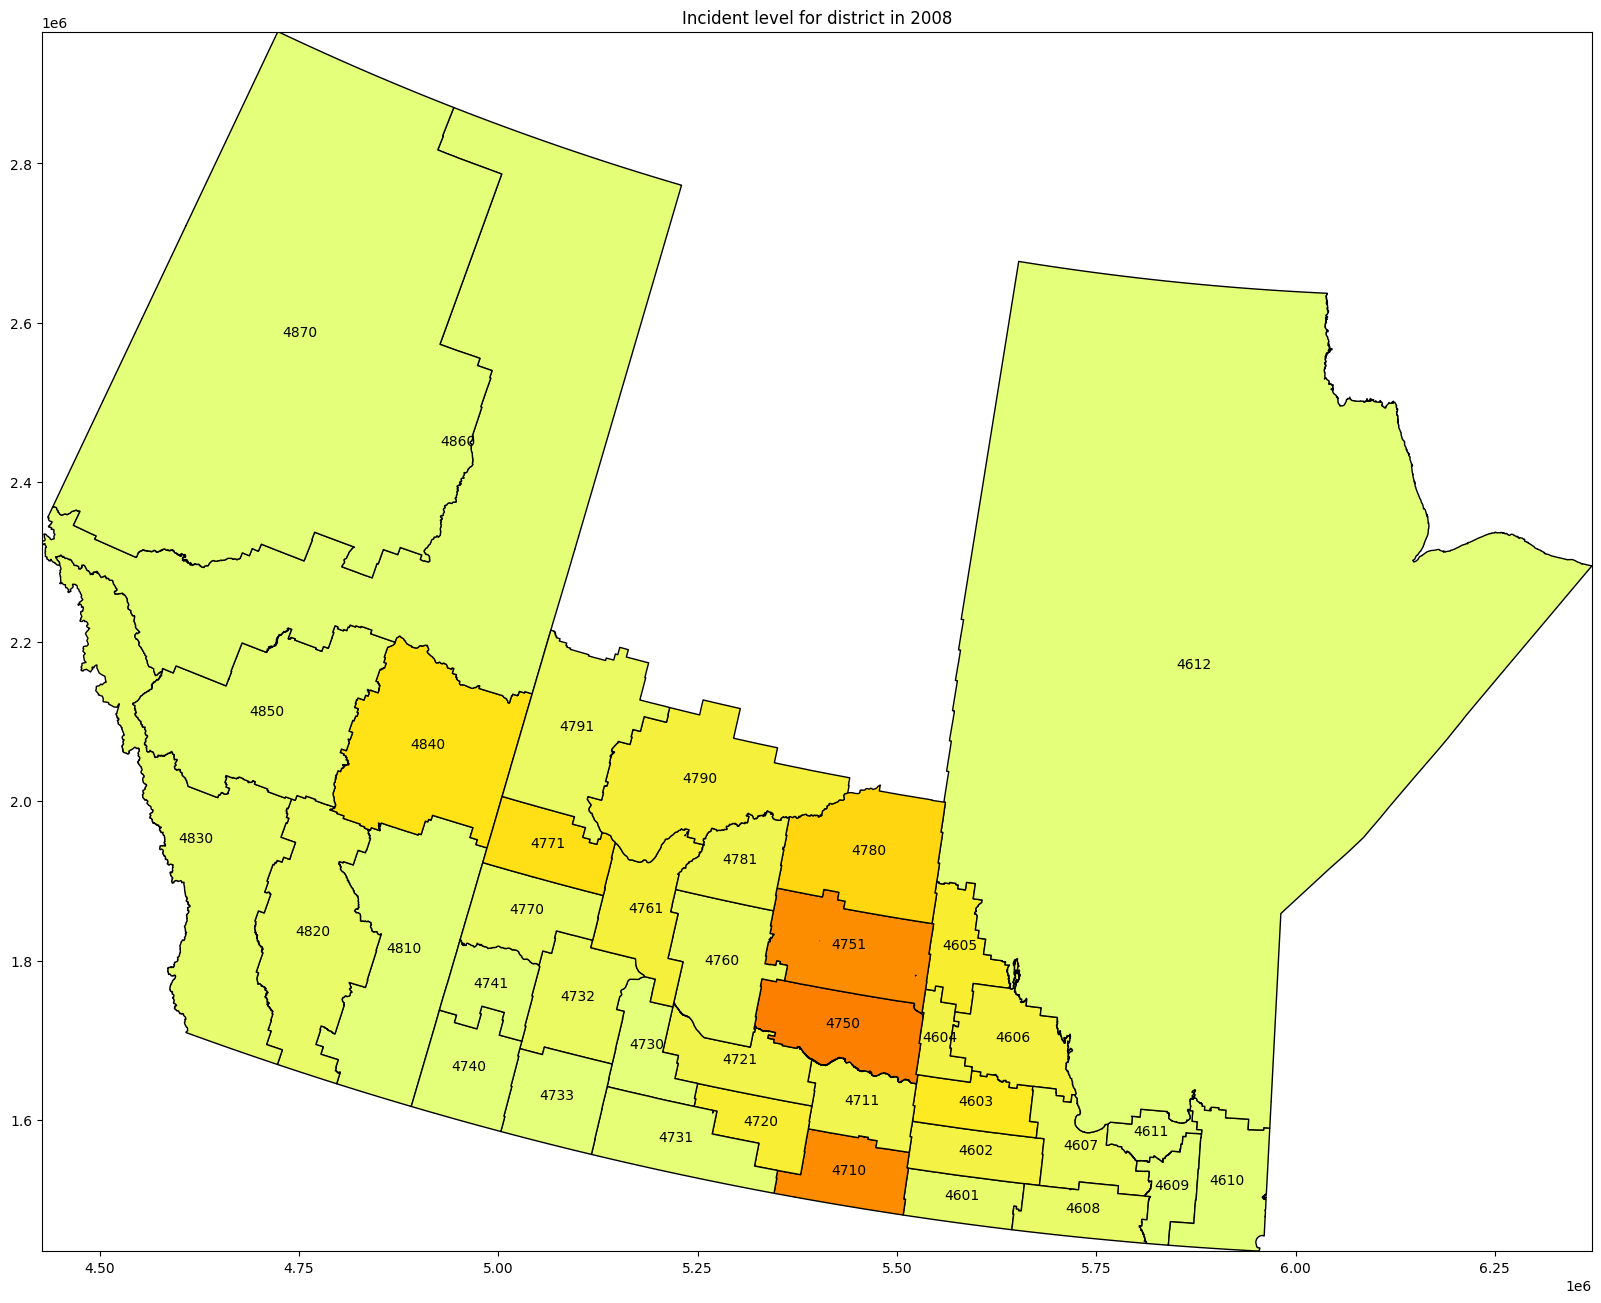

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


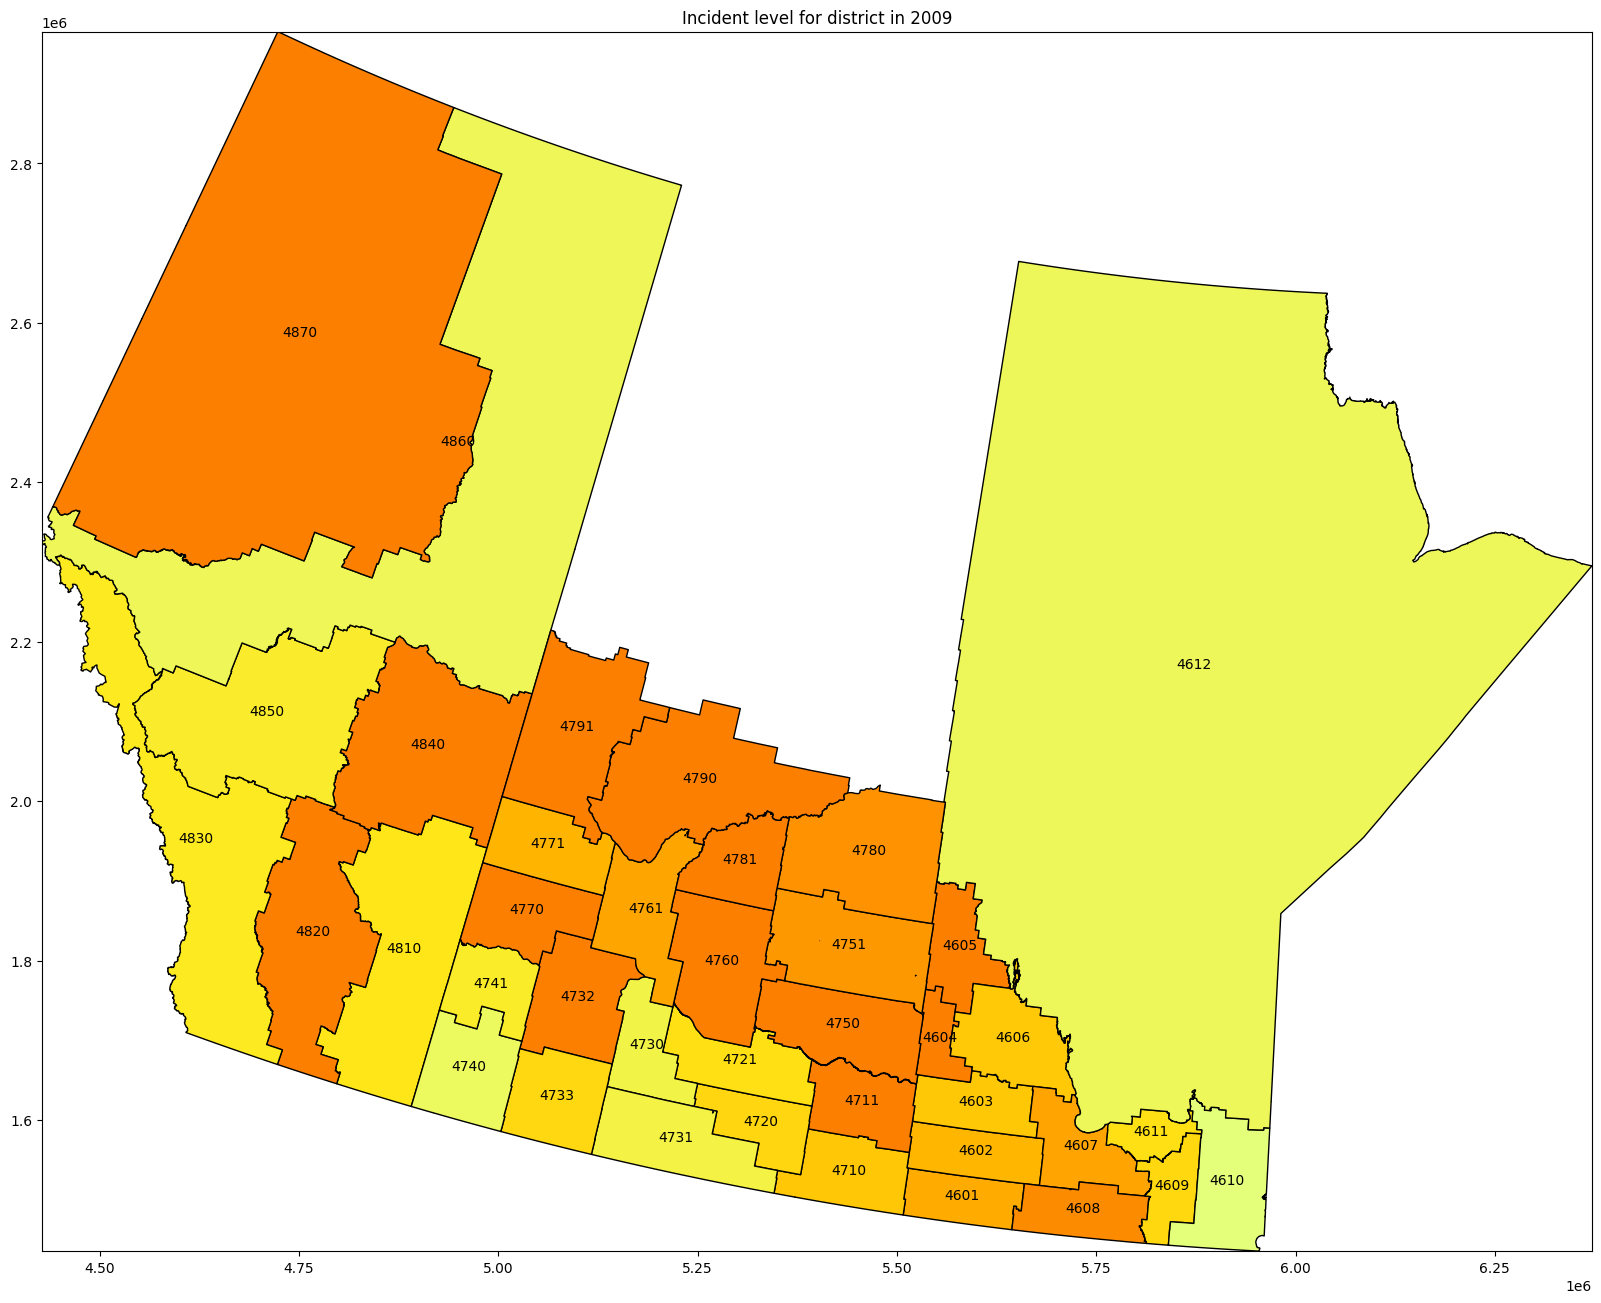

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


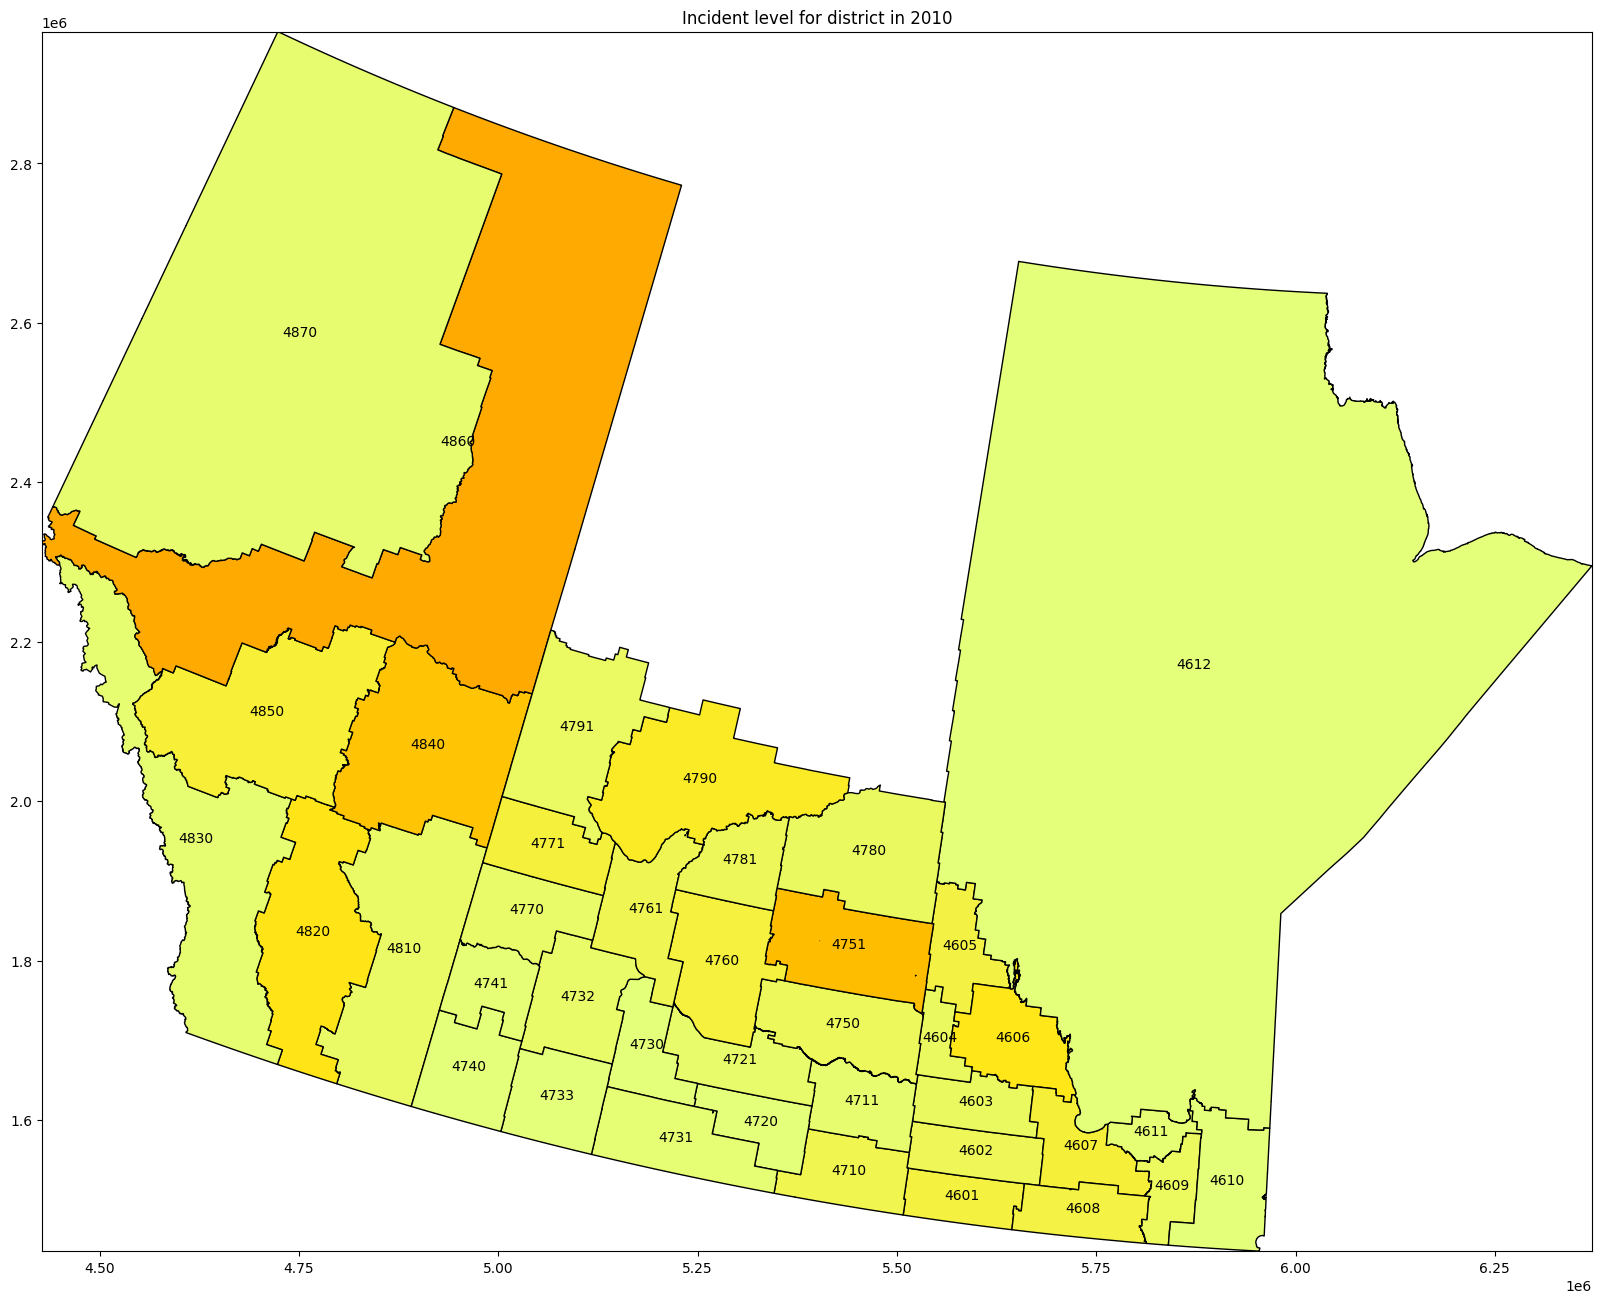

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


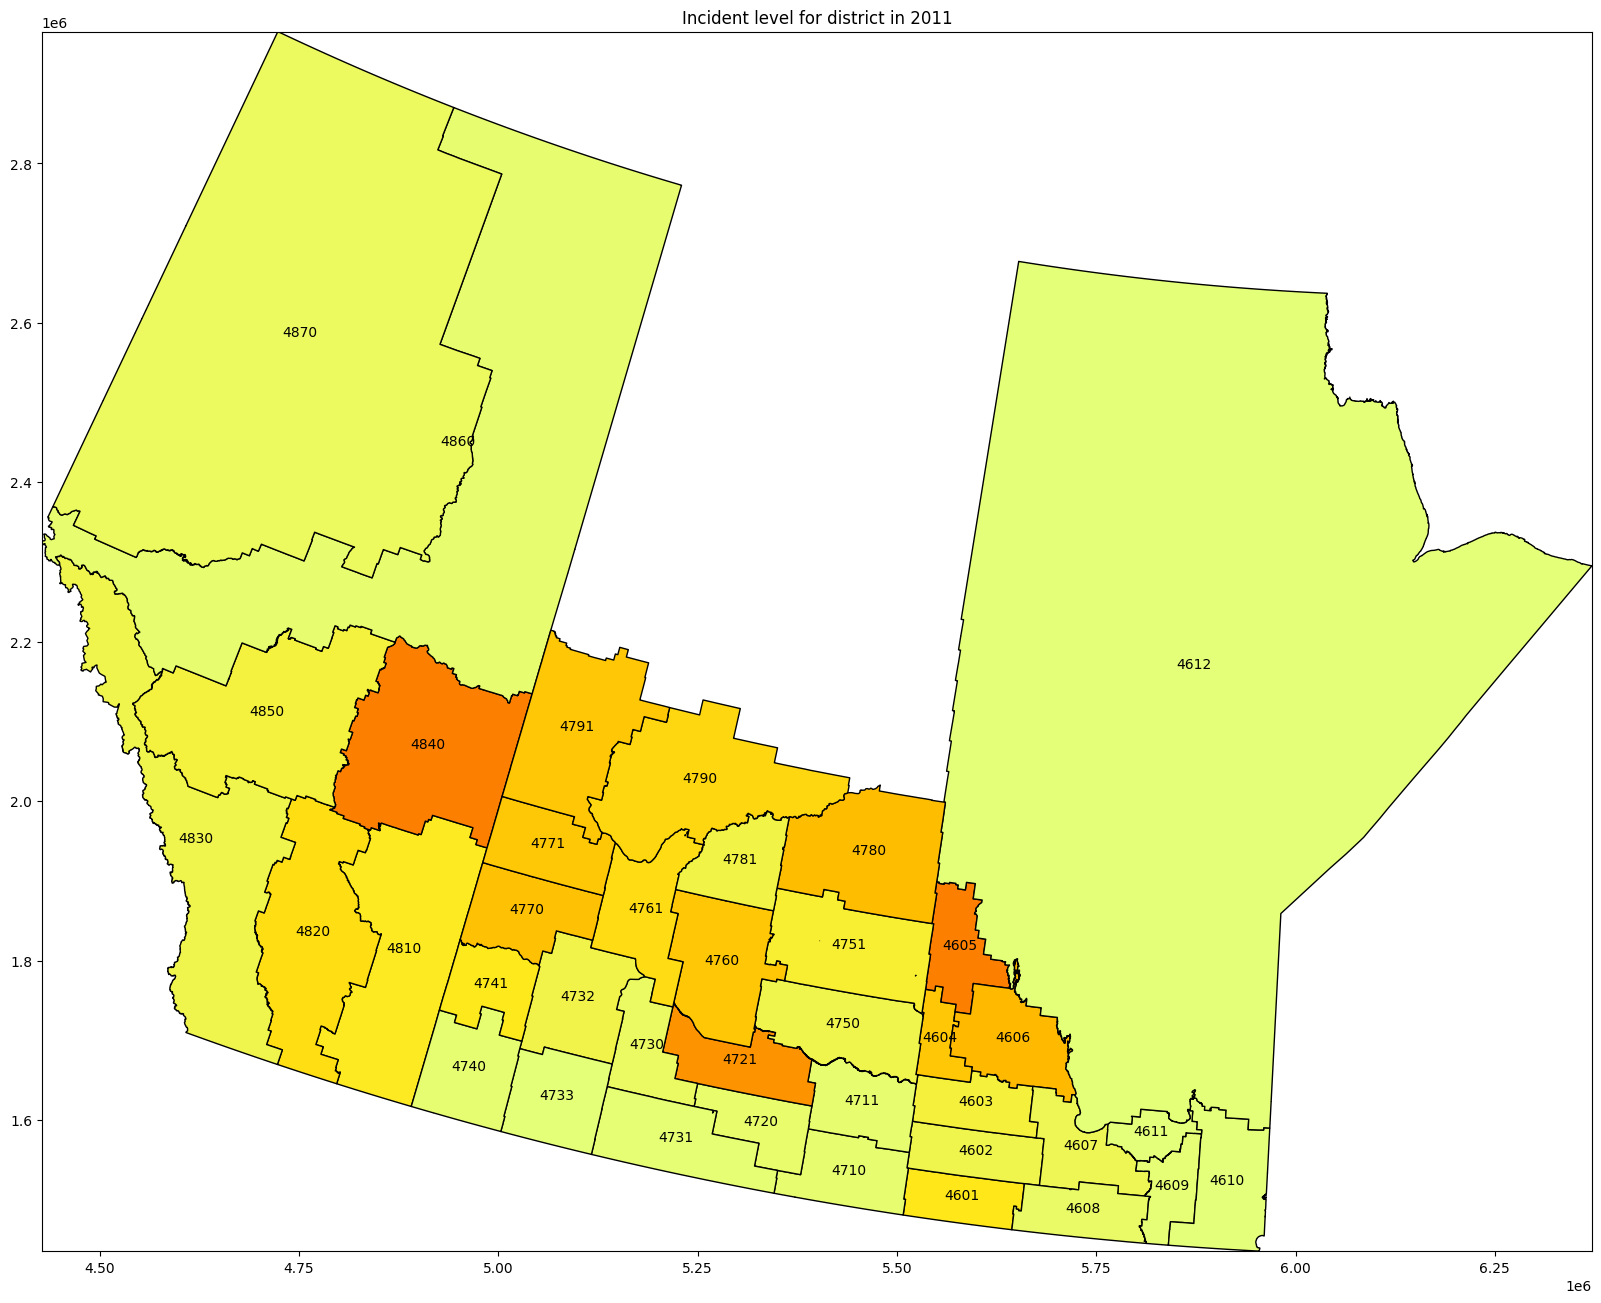

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


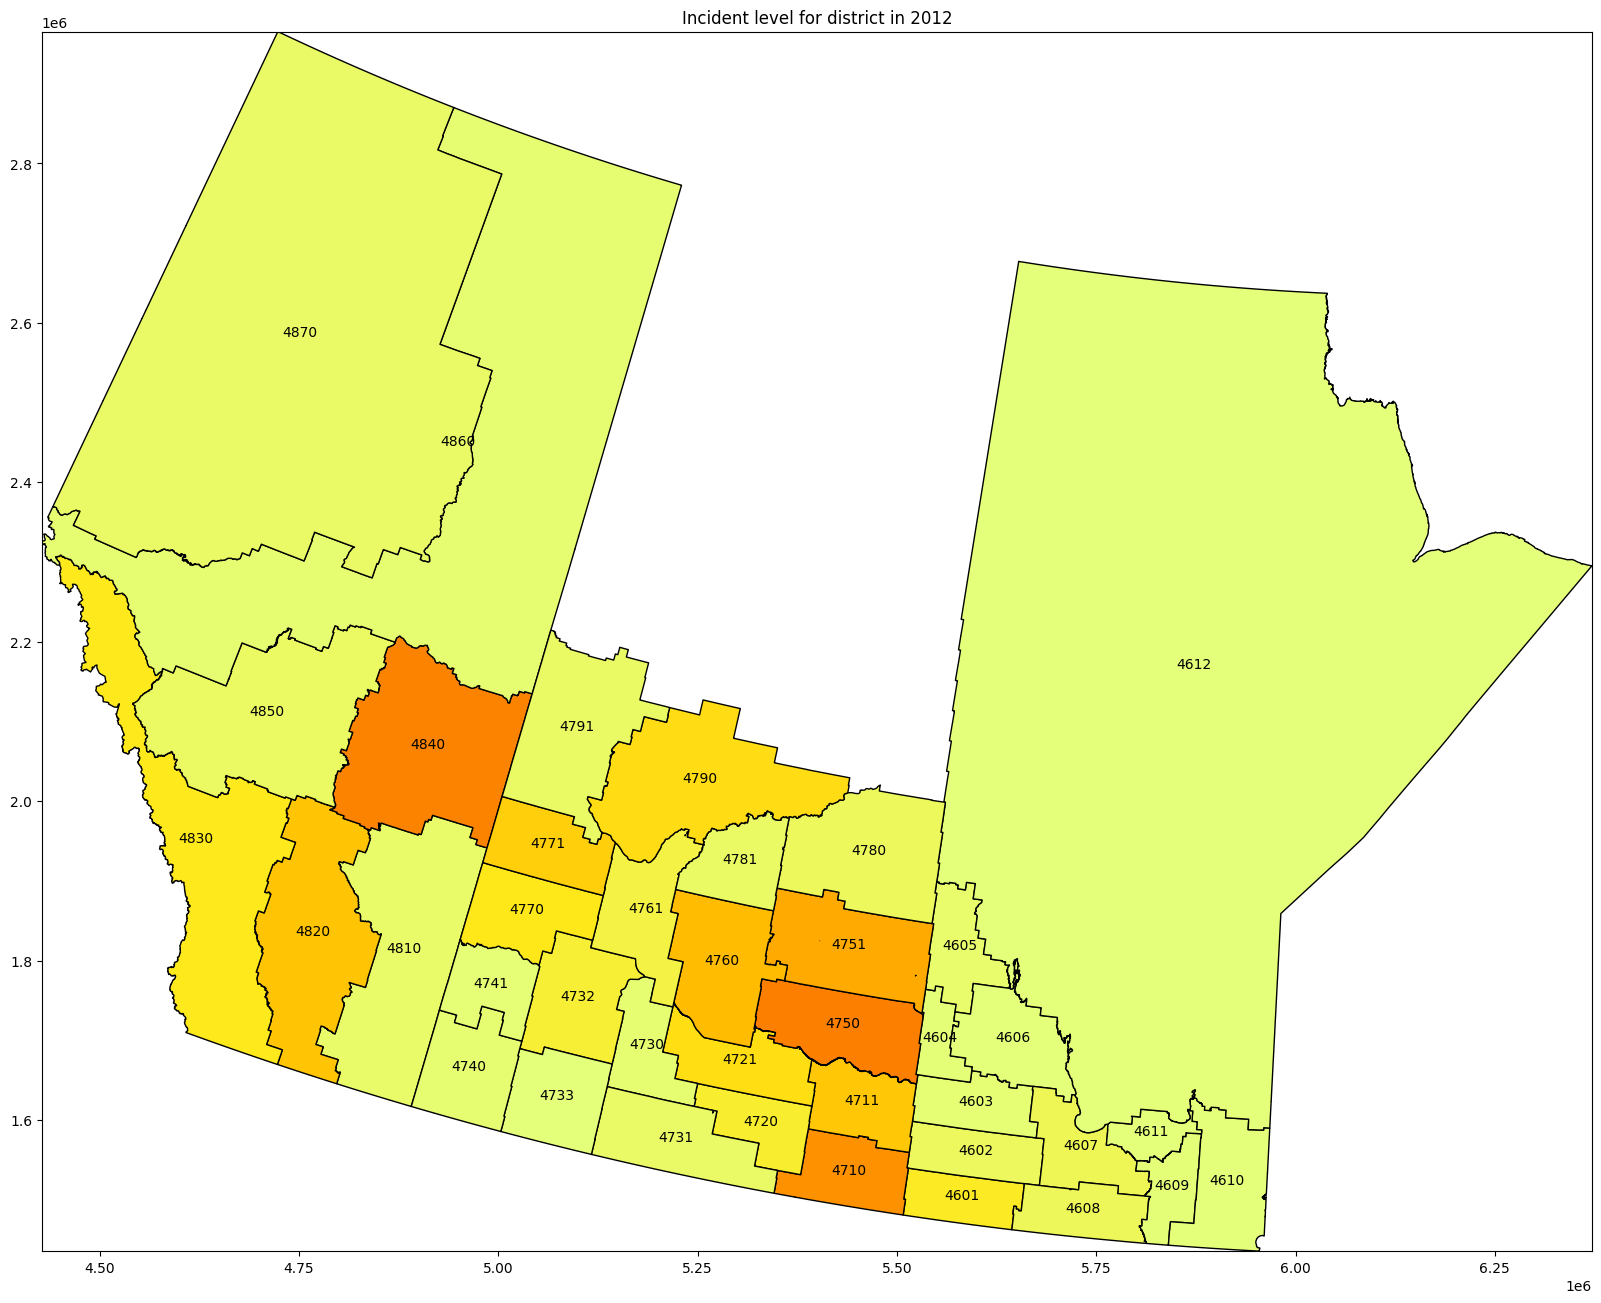

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


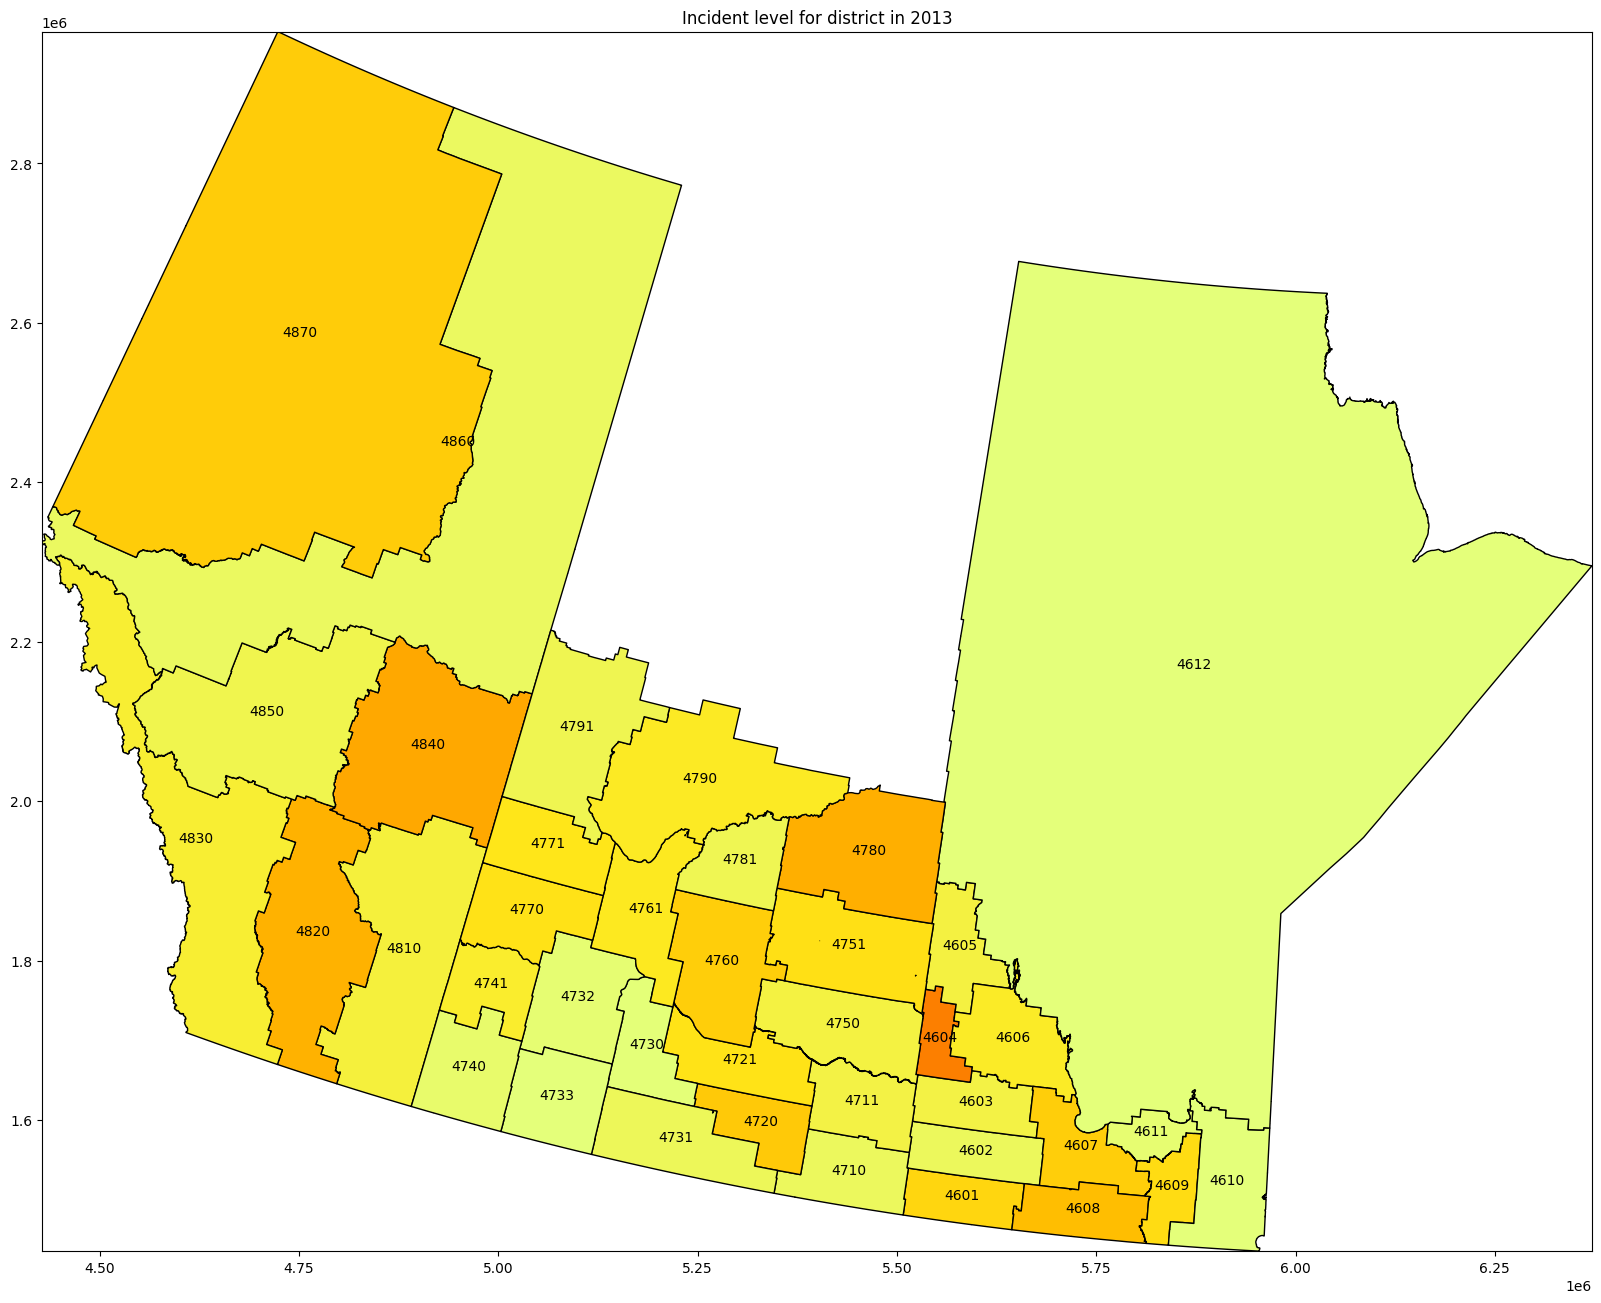

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


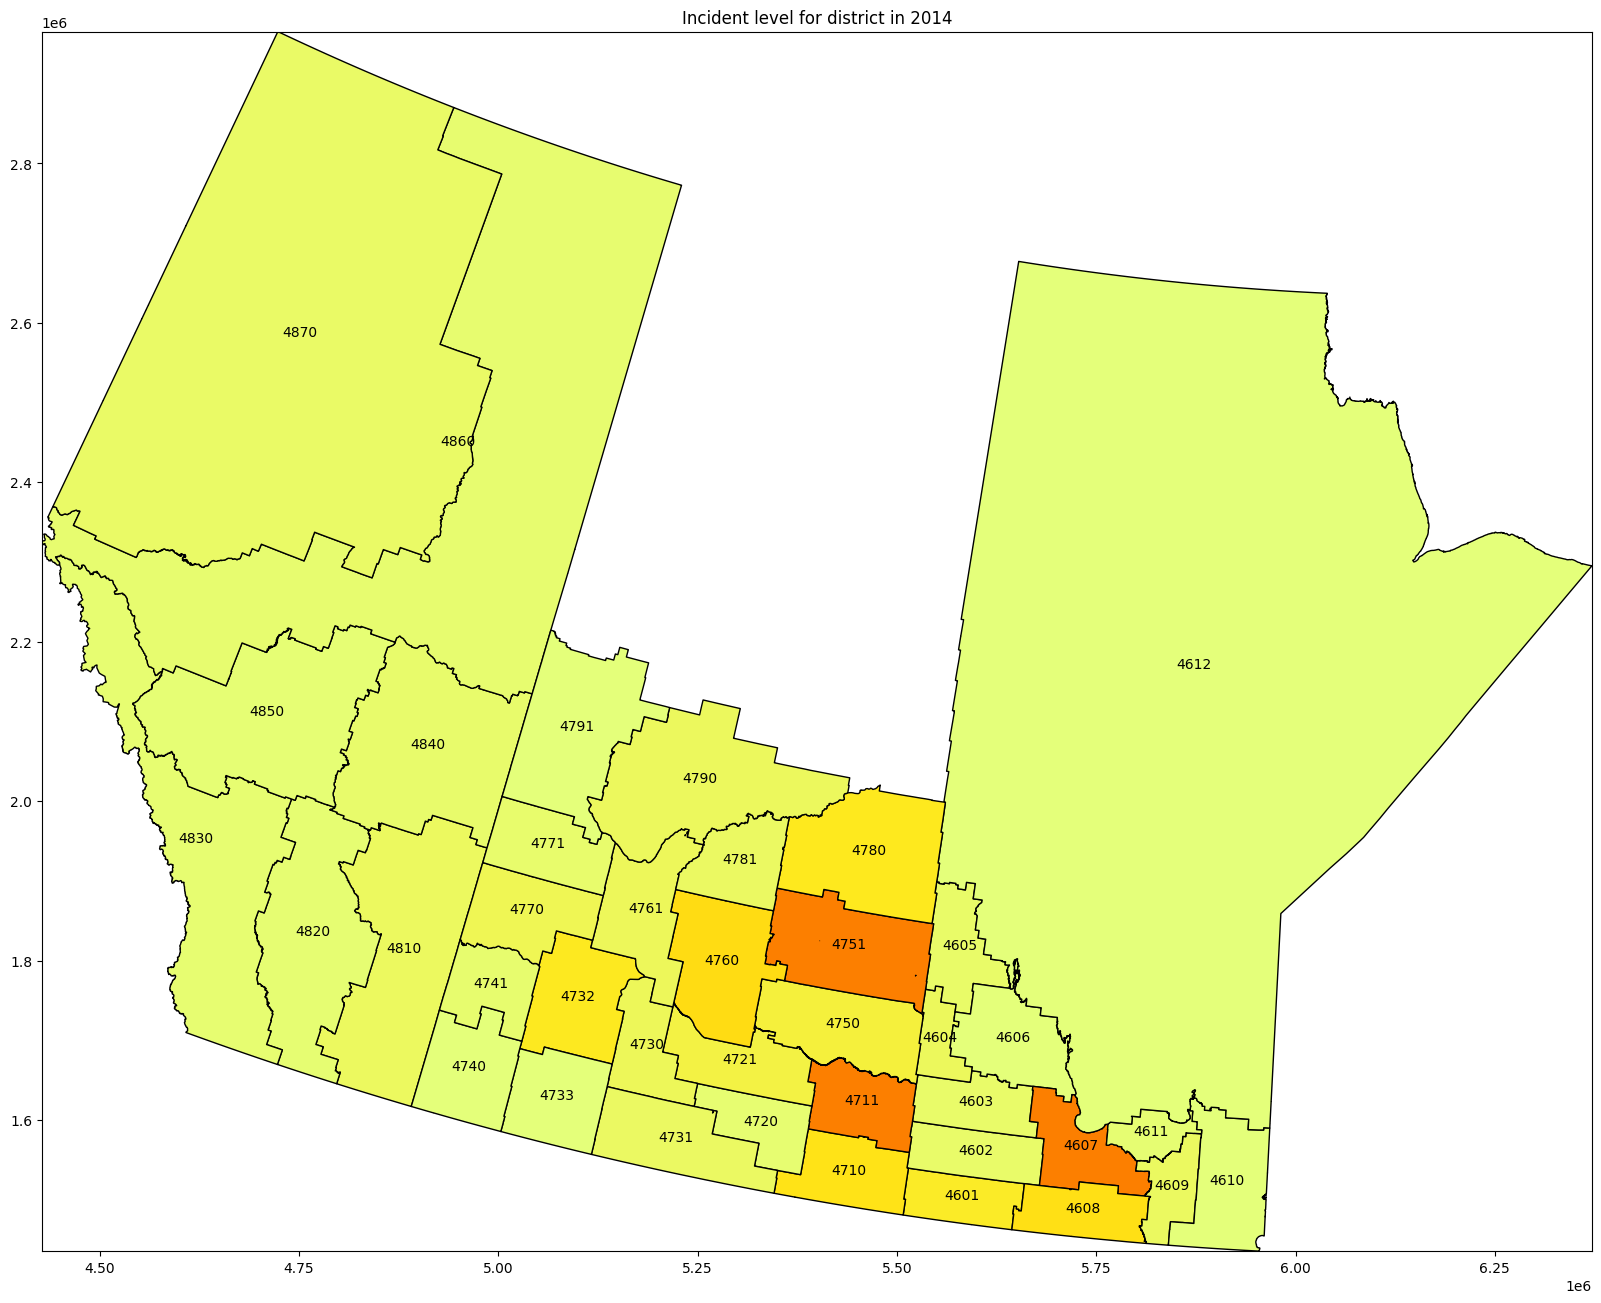

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


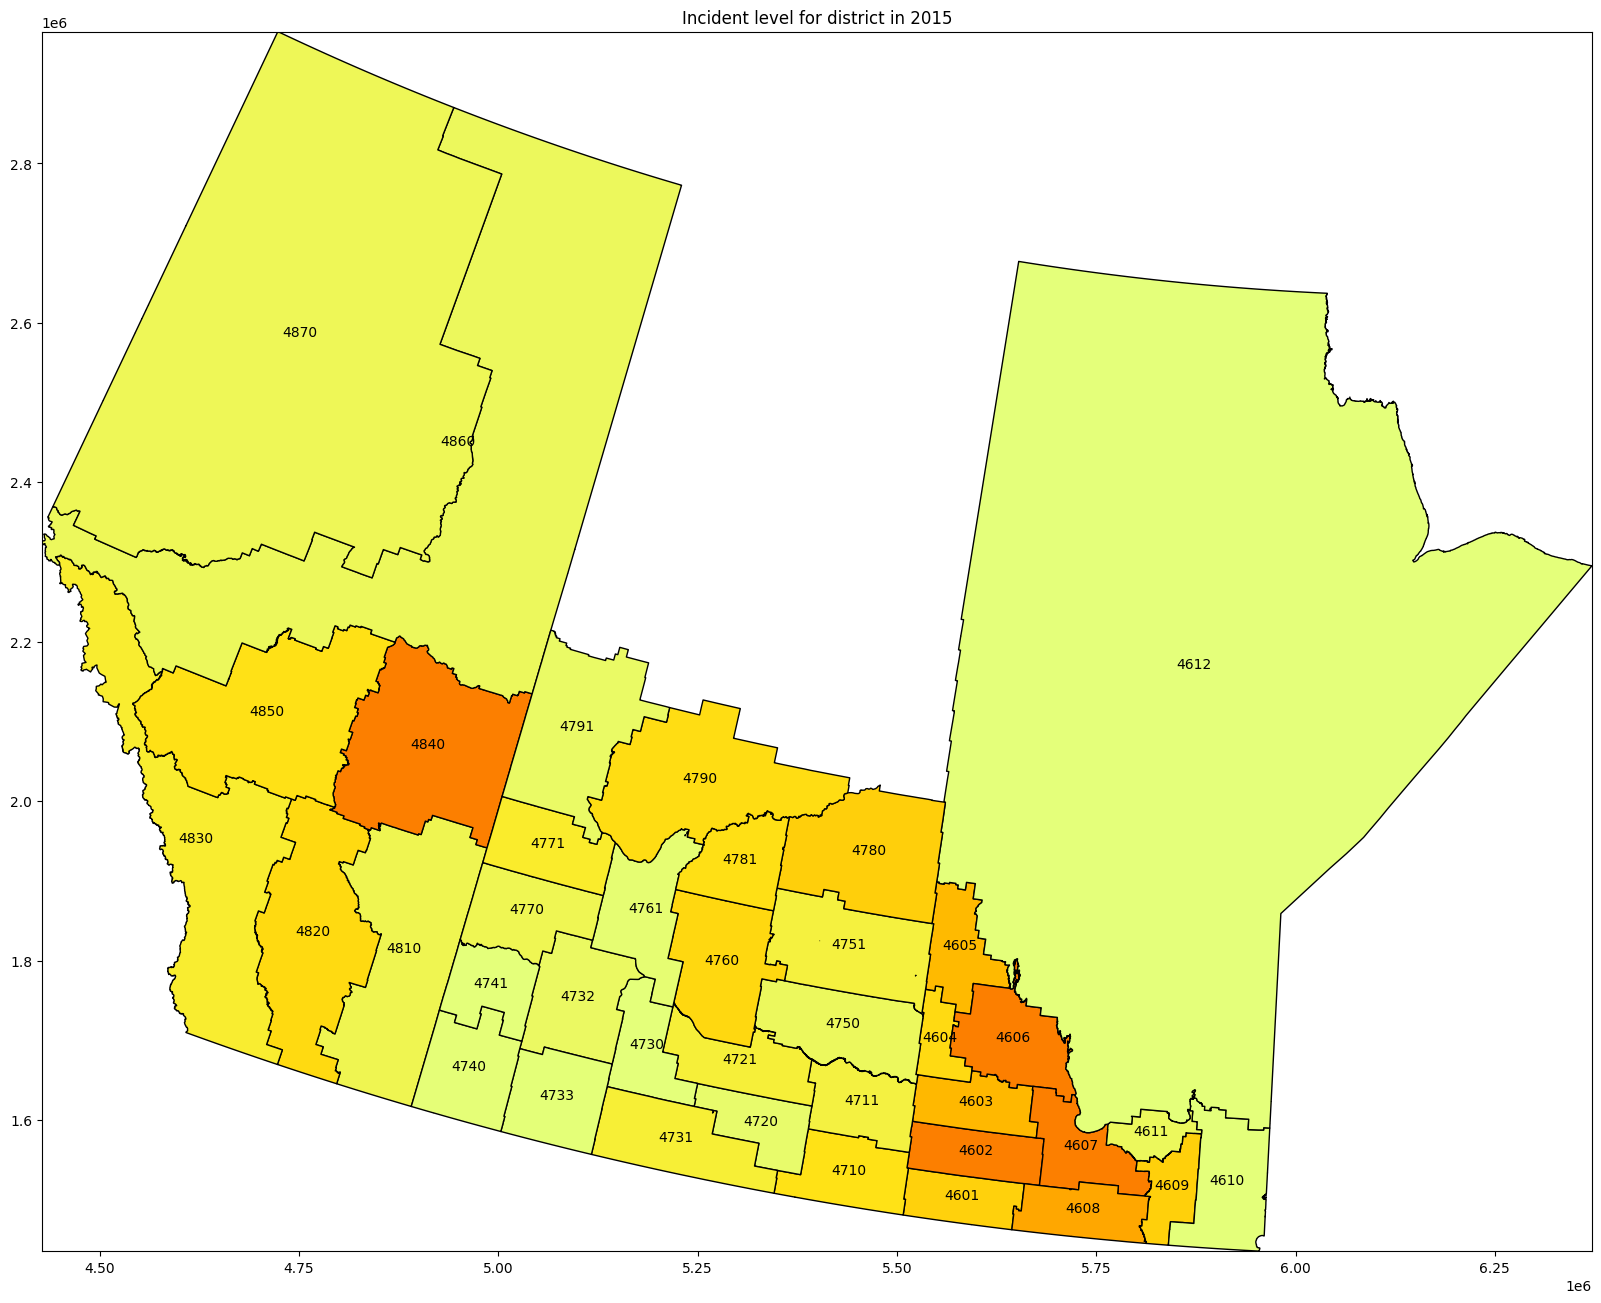

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


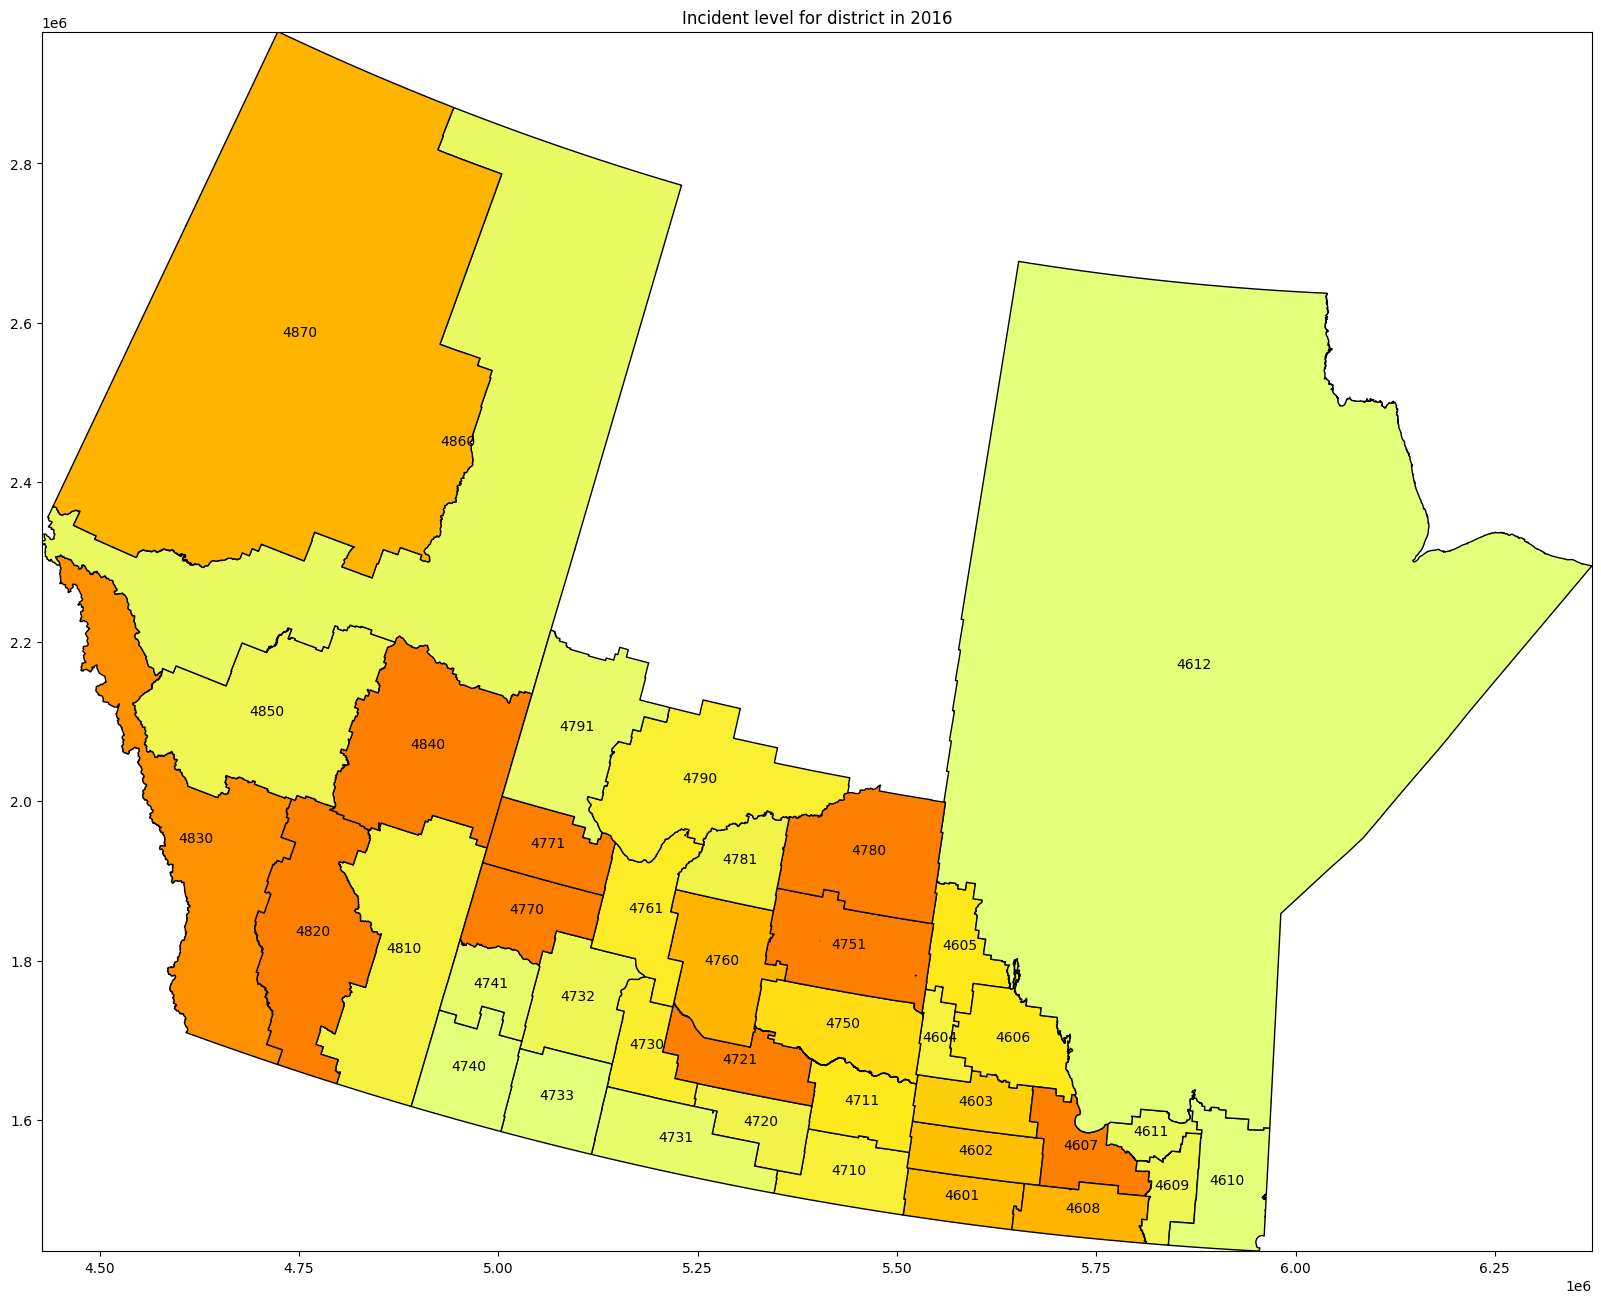

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


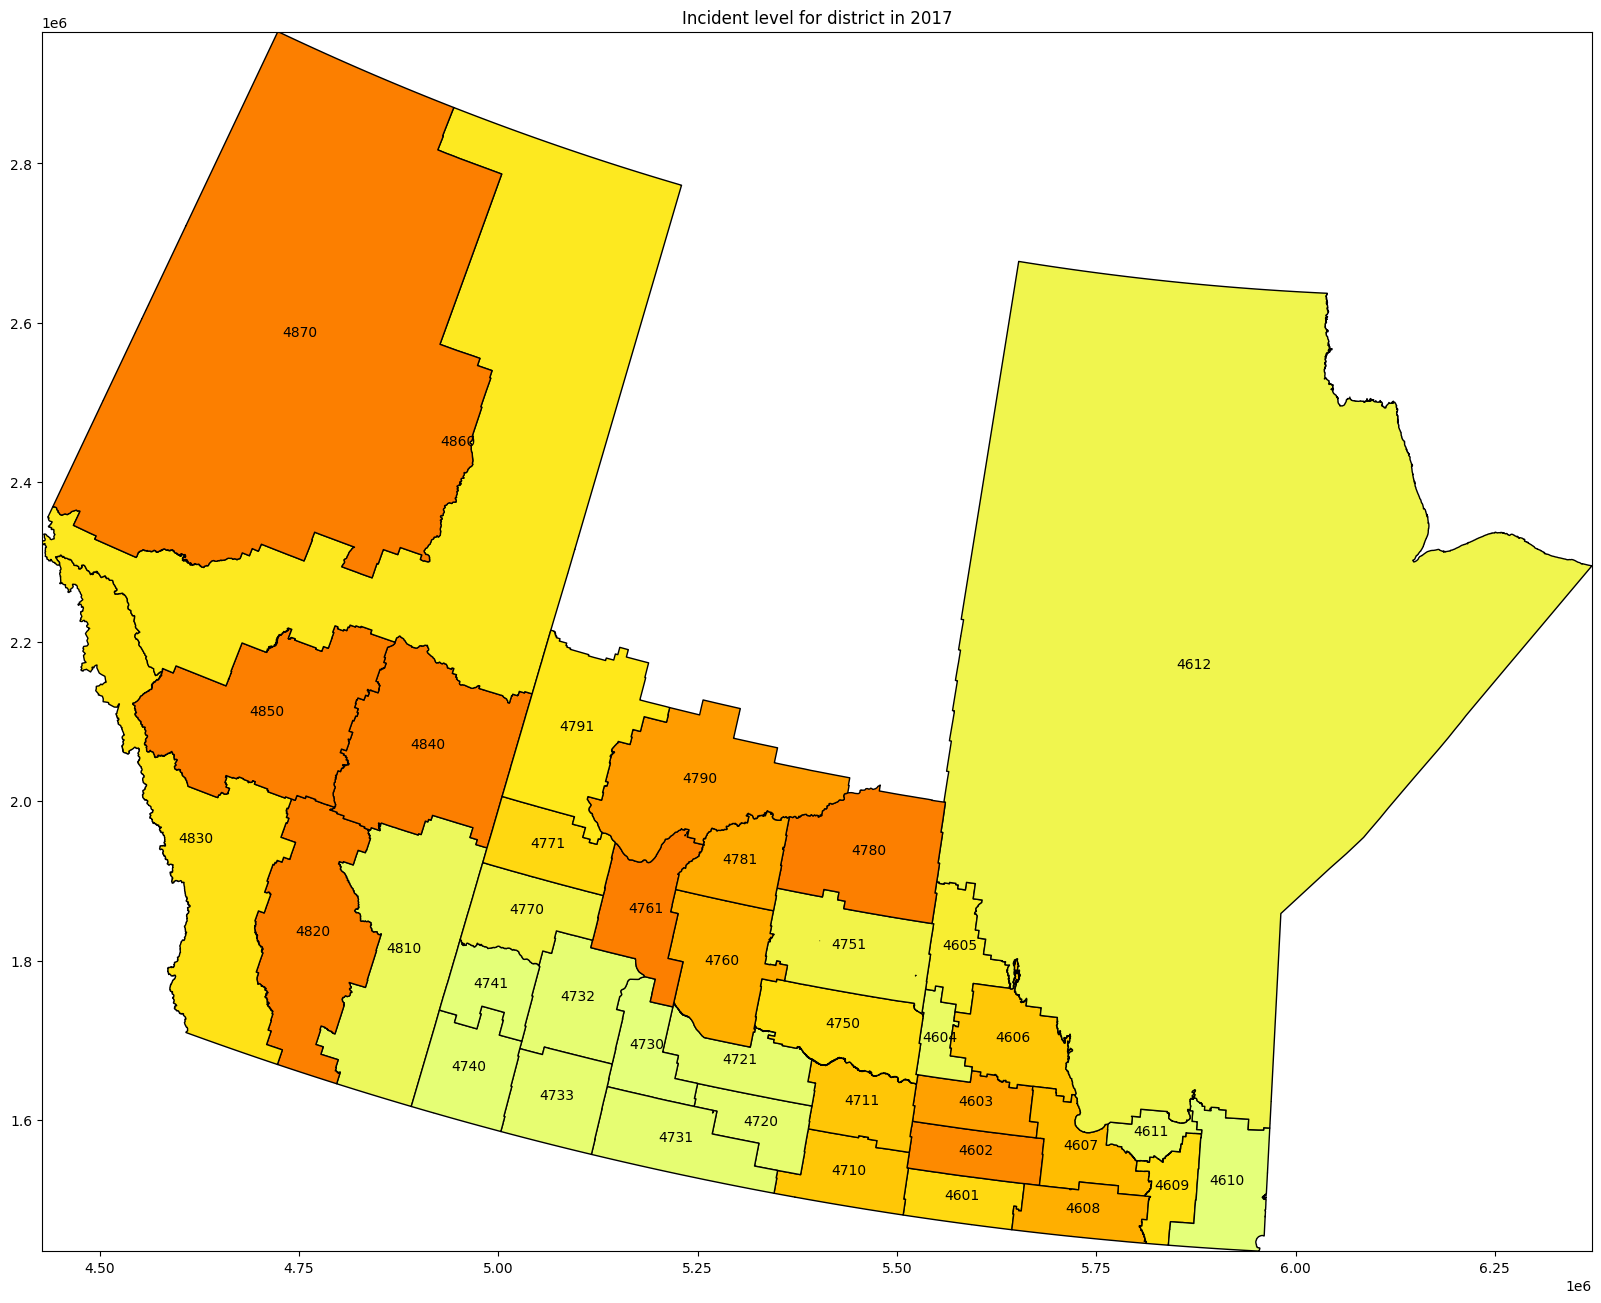

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


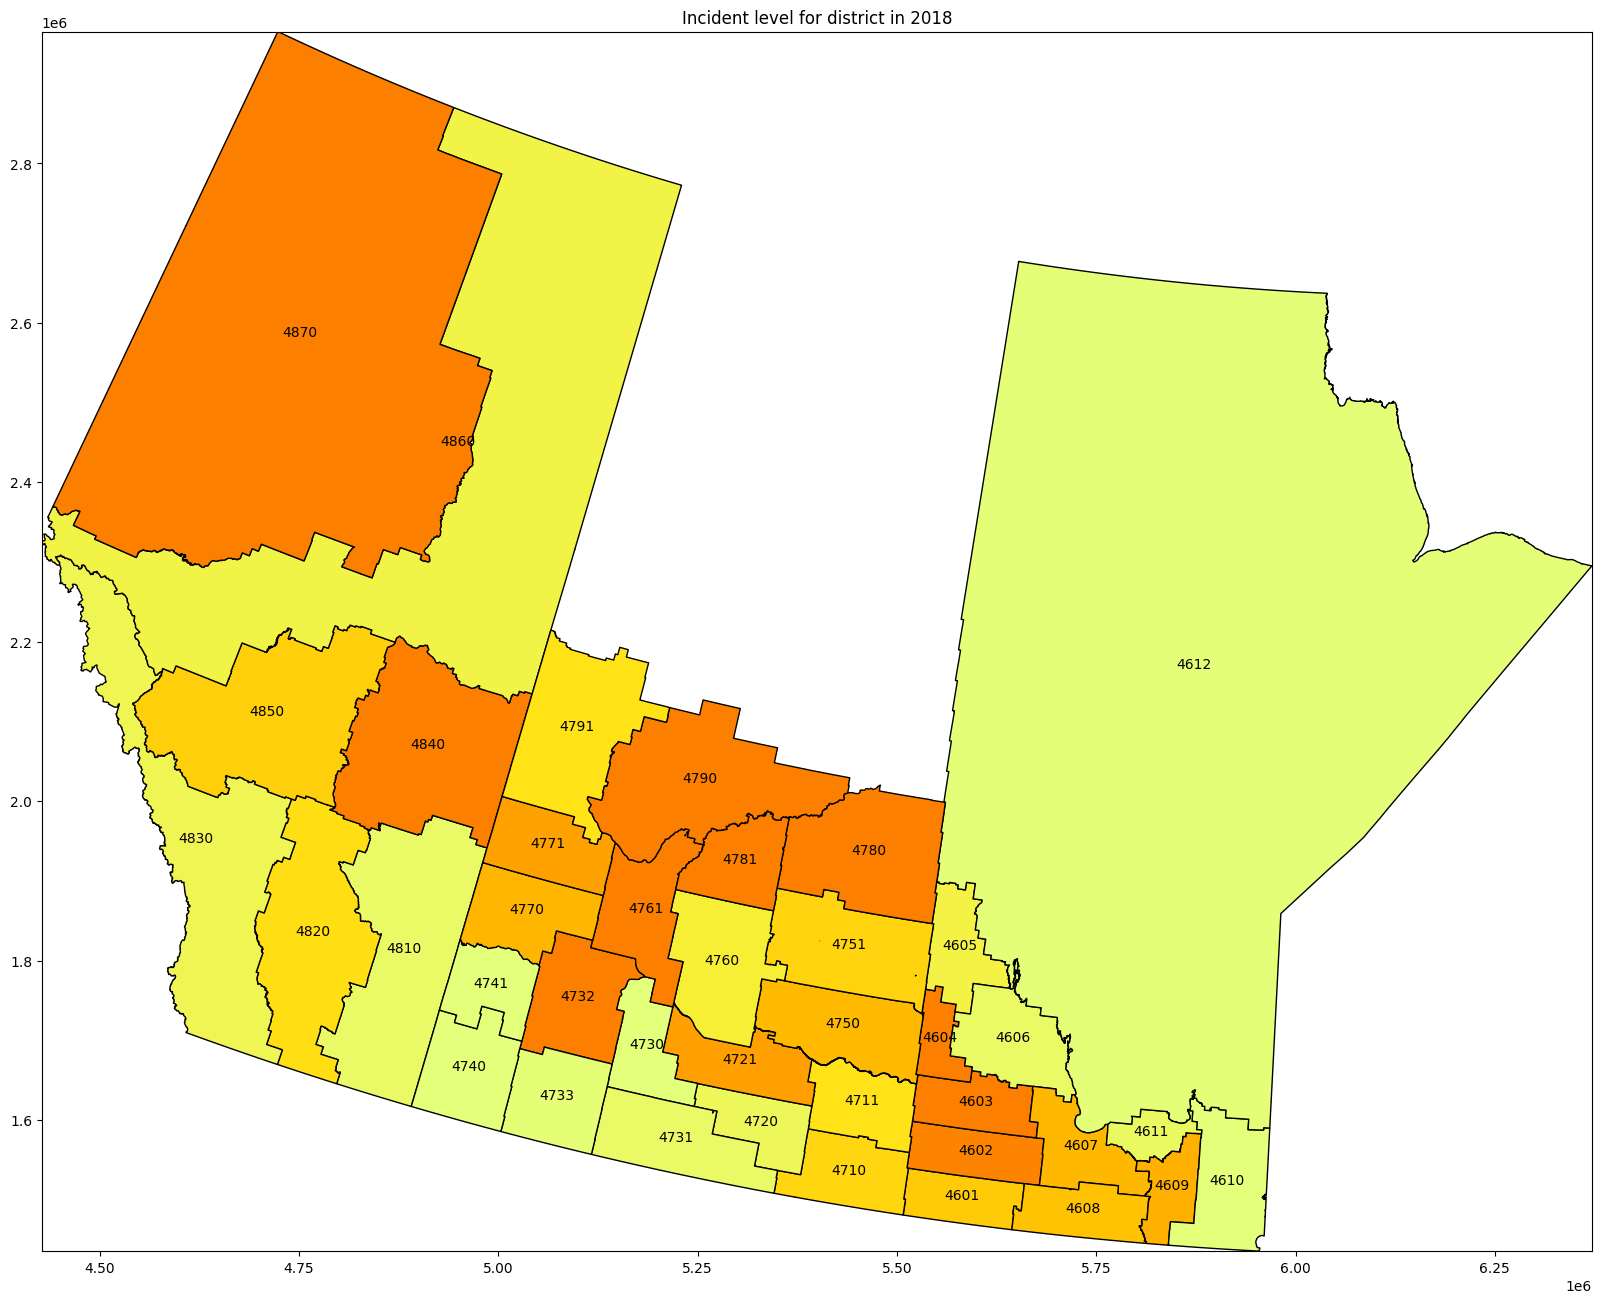

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


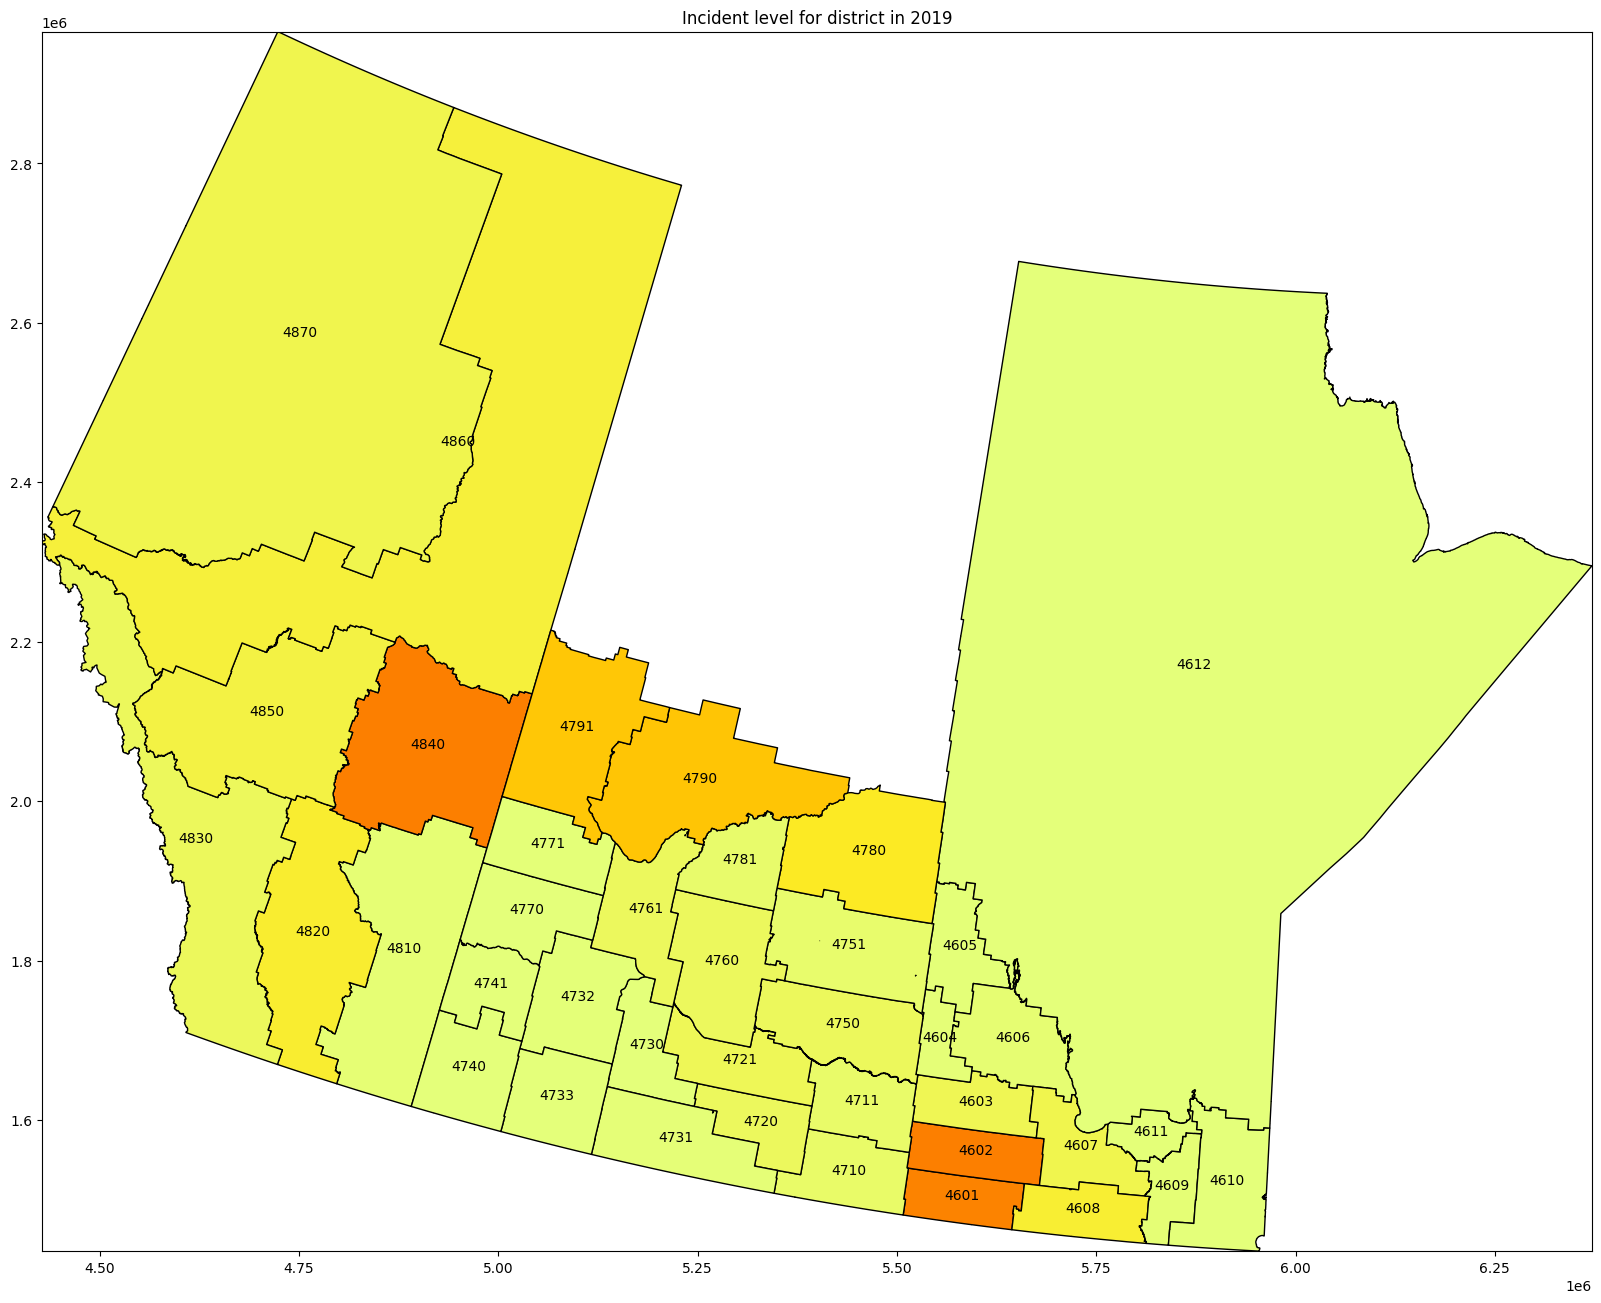

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


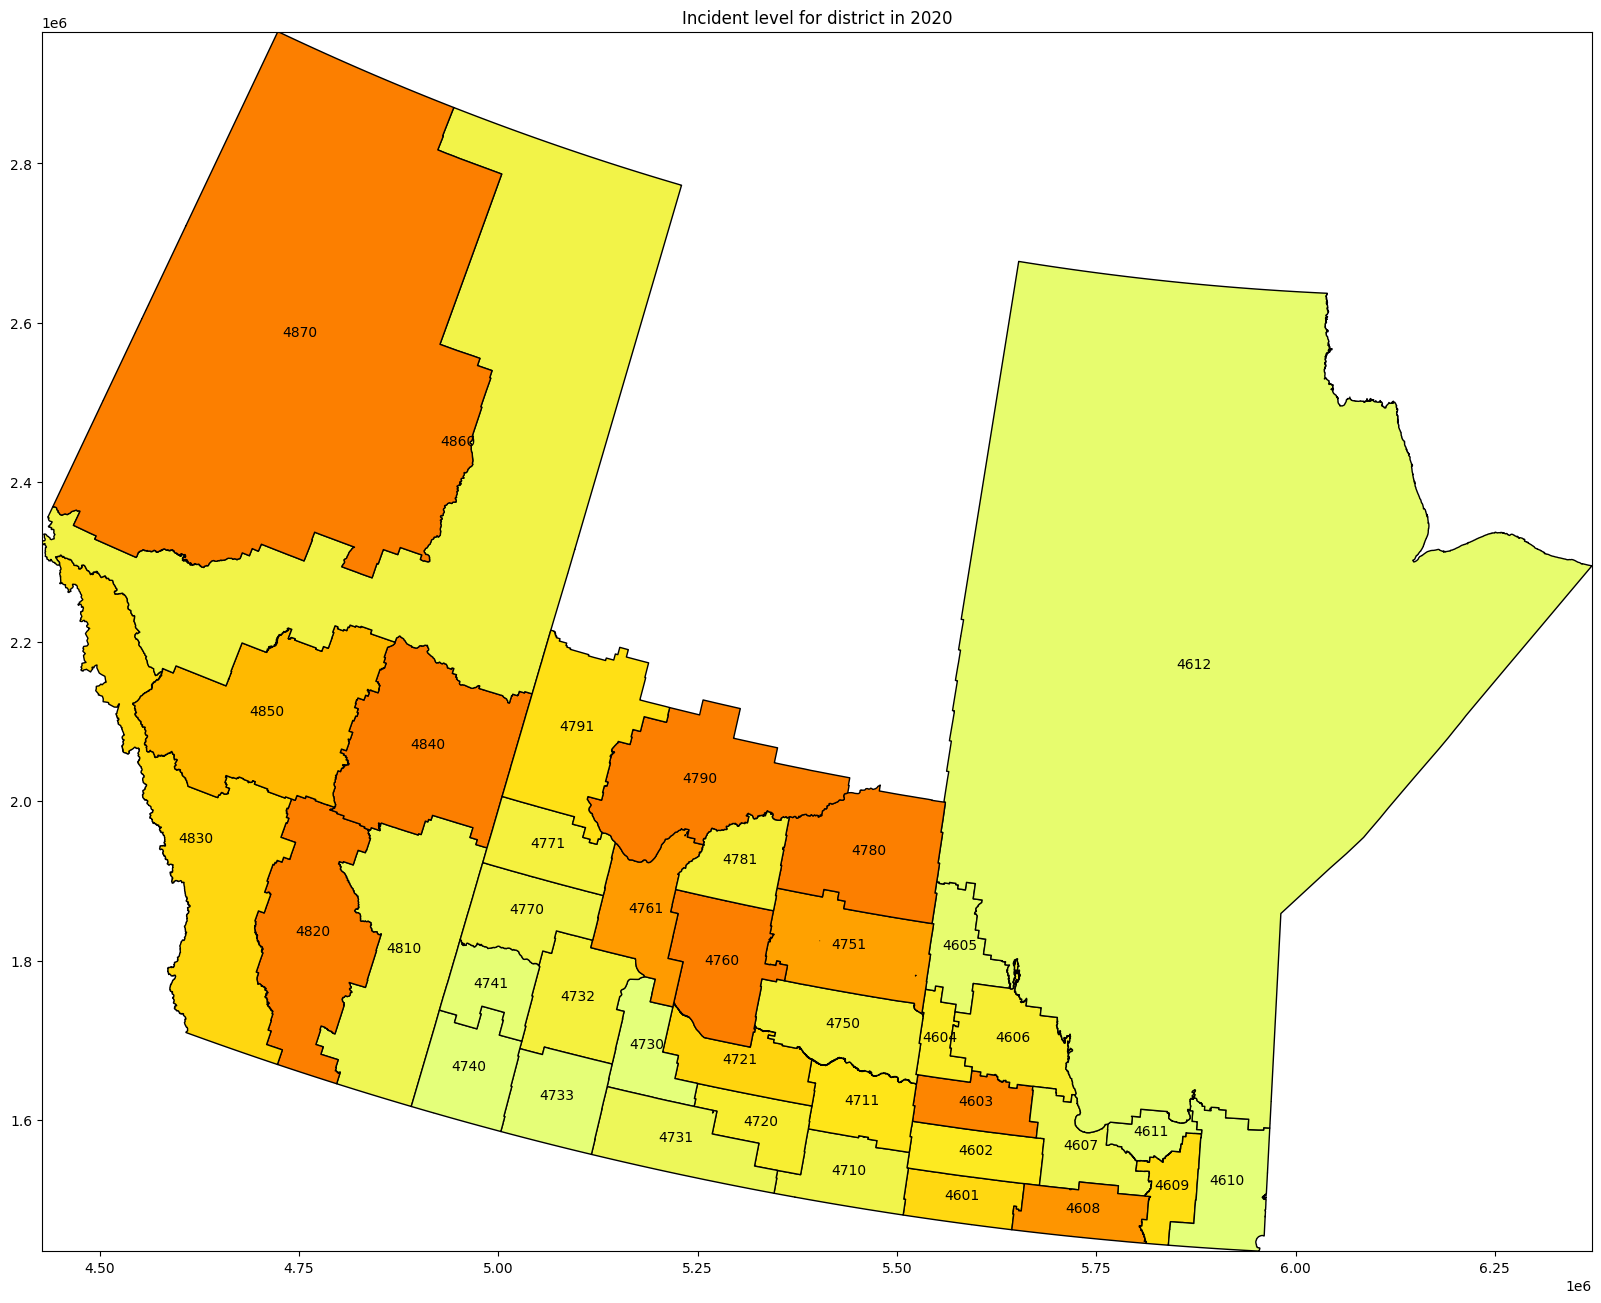

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


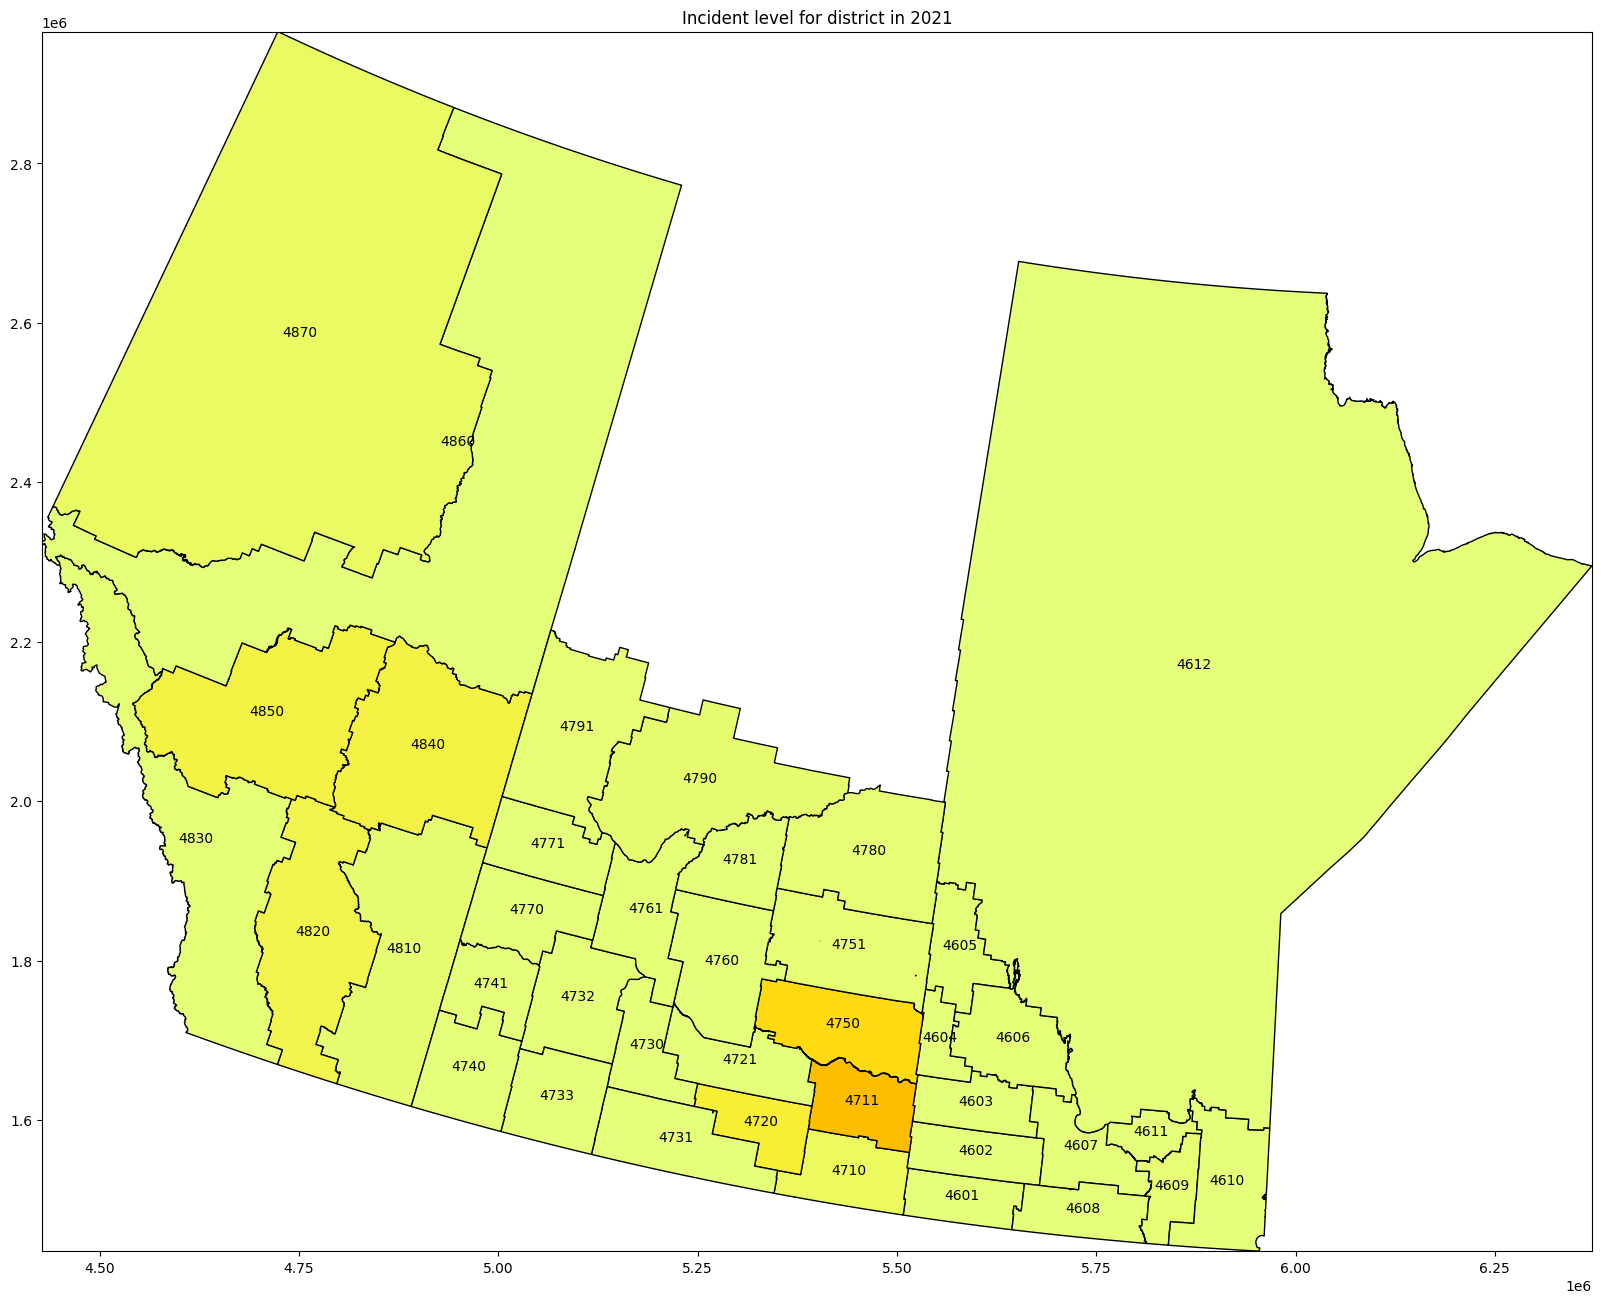

/tmp/ipykernel_1886/29473119.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


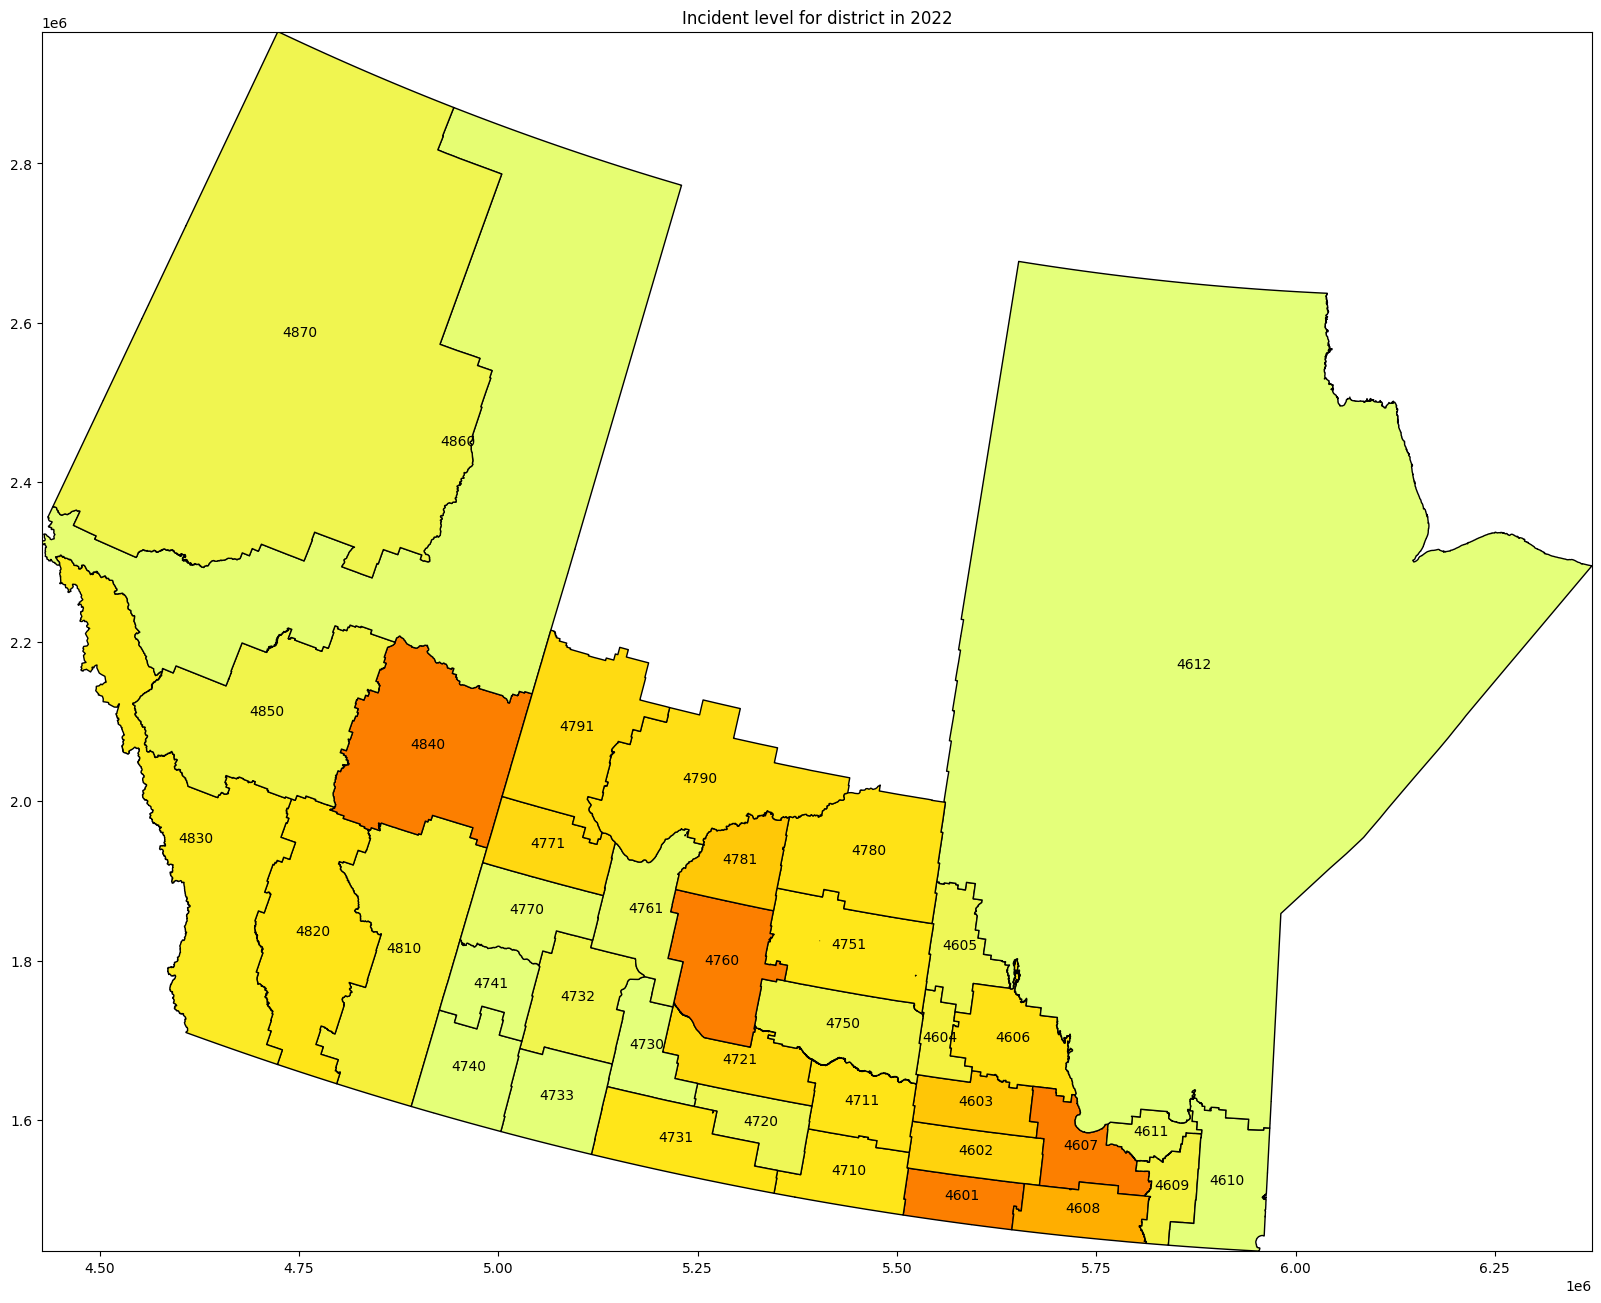

In [17]:
for year in range(1995, 2023):
    ratio_year = region_df.loc[region_df['year'] == year]
    color = get_color(ratio_year)
    plot_map(color, year)

# Visualization for aggregated ergot

In [18]:
query = sq.text("select * FROM public.agg_ergot_samples")
agg_ergot_df = pd.read_sql(query, conn)

In [19]:
agg_ergot_df

sample_id  year province  crop_district  incidence  severity  \
0               1  1995       AB              1      False       0.0   
1               2  1995       AB              1      False       0.0   
2               3  1995       AB              1      False       0.0   
3               4  1995       AB              1      False       0.0   
4               5  1995       AB              1      False       0.0   
...           ...   ...      ...            ...        ...       ...   
158684     158685  2022       SK             81      False       0.0   
158685     158686  2022       SK             81      False       0.0   
158686     158687  2022       SK             81      False       0.0   
158687     158688  2022       AB              7      False       0.0   
158688     158689  2022       AB              7      False       0.0   

        district  percnt_true  has_ergot  sum_severity  present_prev1  \
0           4810     0.000000      False          0.00          False   
1           4810     0.000000      False          0.00          False   
2           4810     0.000000      False          0.00          False   
3           4810     0.000000      False          0.00          False   
4           4810     0.000000      False          0.00          False   
...          ...          ...        ...           ...            ...   
158684      4780     0.244318       True          0.51           True   
158685      4780     0.244318       True          0.51           True   
158686      4780     0.244318       True          0.51           True   
158687      4870     0.180723       True          0.30           True   
158688      4870     0.180723       True          0.30           True   

        present_prev2  present_prev3  present_in_neighbor  severity_prev1  \
0               False          False                False        0.000000   
1               False          False                False        0.000000   
2               False          False                False        0.000000   
3               False          False                False        0.000000   
4               False          False                False        0.000000   
...               ...            ...                  ...             ...   
158684           True           True                 True        0.018182   
158685           True           True                 True        0.018182   
158686           True           True                 True        0.018182   
158687           True           True                 True        0.018433   
158688           True           True                 True        0.018433   

        severity_prev2  severity_prev3  severity_in_neighbor  
0             0.000000        0.000000              0.000000  
1             0.000000        0.000000              0.000000  
2             0.000000        0.000000              0.000000  
3             0.000000        0.000000              0.000000  
4             0.000000        0.000000              0.000000  
...                ...             ...                   ...  
158684        0.274678        0.083784              0.286501  
158685        0.274678        0.083784              0.286501  
158686        0.274678        0.083784              0.286501  
158687        0.369338        0.125964              0.052632  
158688        0.369338        0.125964              0.052632  

[158689 rows x 18 columns]

<Axes: title={'center': 'Severity'}>

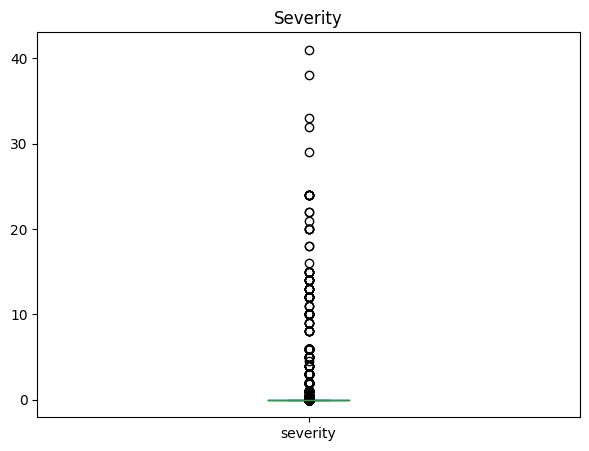

In [38]:
agg_ergot_df.plot.box(title='Severity', column=['severity'])

In [20]:
# incident/present of urgot information by district
present_df = agg_ergot_df[['year', 'has_ergot', 'district', 'present_prev1', 'present_prev2', 'present_prev3', 'present_in_neighbor']].drop_duplicates()
present_df

year  has_ergot  district  present_prev1  present_prev2  \
0       1995      False      4810          False          False   
48      1995      False      4820          False          False   
190     1995       True      4830          False          False   
230     1995       True      4840          False          False   
610     1995       True      4850          False          False   
...      ...        ...       ...            ...            ...   
155512  2022       True      4611          False           True   
155524  2022       True      4606           True           True   
156118  2022      False      4612          False           True   
156195  2022       True      4740          False          False   
157027  2022       True      4733          False           True   

        present_prev3  present_in_neighbor  
0               False                False  
48              False                 True  
190             False                 True  
230             False                False  
610             False                 True  
...               ...                  ...  
155512           True                 True  
155524           True                 True  
156118          False                 True  
156195          False                 True  
157027          False                 True  

[1063 rows x 7 columns]

In [30]:
# find percentage of having ergot in previous year -> having ergot in this year
percent1 = present_df[(present_df['has_ergot'] == True) & (present_df['present_prev1'] == True)].shape[0]/present_df.shape[0]
print('Percent of having ergot when prev year had ergot: ', percent1)

# find percentage of having ergot in previous 2 years -> having ergot in this year
percent2 = present_df[(present_df['has_ergot'] == True) & (present_df['present_prev2'] == True)].shape[0]/present_df.shape[0]
print('Percent of having ergot when prev 2 year had ergot: ', percent2)

# find percentage of having ergot when having ergot in previous 3 year
percent3 = present_df[(present_df['has_ergot'] == True) & (present_df['present_prev3'] == True)].shape[0]/present_df.shape[0]
print('Percent of having ergot when prev 3 year had ergot: ', percent3)

# find percentage of having ergot when neighbor has ergot
percent4 = present_df[(present_df['has_ergot'] == True) & (present_df['present_in_neighbor'] == True)].shape[0]/present_df.shape[0]
print('Percent of having ergot when neighbor is having ergot: ', percent4)


Percent of having ergot when prev year had ergot 0.6999059266227657
Percent of having ergot when prev 2 year had ergot 0.6923800564440263
Percent of having ergot when prev 3 year had ergot 0.6622765757290687
Percent of having ergot when neighbor is having ergot 0.819379115710254


In [32]:
# severity information by district
severity_df = agg_ergot_df[['year', 'district', 'has_ergot', 'sum_severity', 'severity_prev1', 'severity_prev2', 'severity_prev3']].drop_duplicates()
severity_df

year  district  has_ergot  sum_severity  severity_prev1  \
0       1995      4810      False         0.000        0.000000   
48      1995      4820      False         0.000        0.000000   
190     1995      4830       True        11.000        0.000000   
230     1995      4840       True        15.000        0.000000   
610     1995      4850       True         7.000        0.000000   
...      ...       ...        ...           ...             ...   
155512  2022      4611       True         0.070        0.000000   
155524  2022      4606       True         0.122        0.020833   
156118  2022      4612      False         0.000        0.000000   
156195  2022      4740       True         0.010        0.000000   
157027  2022      4733       True         0.020        0.000000   

        severity_prev2  severity_prev3  
0             0.000000        0.000000  
48            0.000000        0.000000  
190           0.000000        0.000000  
230           0.000000        0.000000  
610           0.000000        0.000000  
...                ...             ...  
155512        0.235294        0.043478  
155524        0.243243        0.026549  
156118        0.454545        0.000000  
156195        0.000000        0.000000  
157027        0.250000        0.000000  

[1063 rows x 7 columns]

<Axes: title={'center': 'Severity'}>

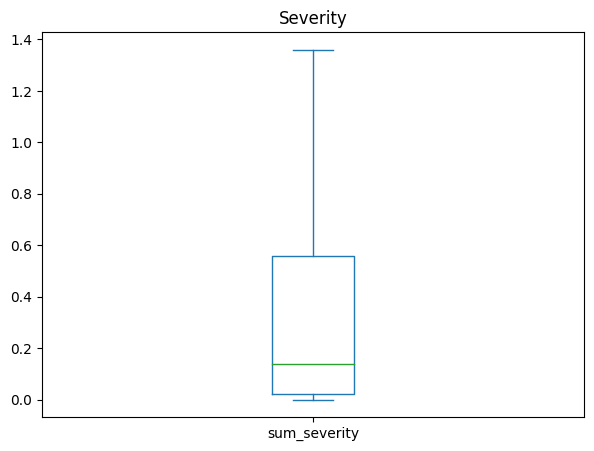

In [40]:
# plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# plot
severity_df.plot.box(title='Severity', column=['sum_severity'], showfliers=False)